# Ukraine War Sentiment Analysis
Analisi del sentiment sui commenti Reddit e YouTube relativi alla guerra in Ucraina, 
con focus sui cambiamenti in corrispondenza di eventi politici legati a Trump.


## 1. Setup e Import delle Librerie

In [85]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# NLP e Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocessing
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

print("Setup completato!")

Setup completato!


## 2. Definizione delle Keywords e Funzioni Utility

In [86]:
# Keywords per identificare contenuti relativi alla guerra in Ucraina
ukraine_war_keywords = [
    # Core conflict terms
    "ukraine", "russia", "putin", "moscow", "kyiv", "kiev", "donbas", "donetsk", 
    "crimea", "invasion", "war", "frontline", "nato", "zelensky", "kremlin",
    "kherson", "mariupol", "kharkiv", "luhansk", "strike", "missile", "tank", 
    "artillery", "offensive", "defense", "sanctions", "ceasefire", "peace",
    
    # Italian
    "ucraina", "mosca", "donbass", "guerra", "attacco", "bombardamento", 
    "missile", "truppe", "soldati", "resistenza", "propaganda", "pace",
    
    # French
    "russie", "poutine", "guerre", "armée", "front", "attaque", 
    "bombardement", "chars", "soldats", "crimee",
    
    # Additional relevant terms
    "humanitarian", "refugees", "aid", "weapons", "military", "conflict",
    "casualties", "civilian", "evacuation", "siege"
]

def contains_war_keywords(text, keywords=ukraine_war_keywords):
    """Controlla se il testo contiene almeno una keyword relativa alla guerra"""
    if pd.isna(text):
        return False
    text_lower = str(text).lower()
    return any(keyword.lower() in text_lower for keyword in keywords)

def preprocess_text(text):
    """Preprocessing del testo per la sentiment analysis"""
    if pd.isna(text):
        return ""
    
    # Converti in stringa e lowercase
    text = str(text).lower()
    
    # Rimuovi URL
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Rimuovi menzioni Reddit/social
    text = re.sub(r'u/\w+|r/\w+|@\w+', '', text)
    
    # Rimuovi caratteri speciali mantenendo punteggiatura base
    text = re.sub(r'[^\w\s.,!?-]', ' ', text)
    
    # Rimuovi spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def convert_to_datetime(timestamp_col):
    """Converte timestamp in datetime, gestendo diversi formati"""
    if pd.api.types.is_numeric_dtype(timestamp_col):
        # Unix timestamp
        dt = pd.to_datetime(timestamp_col, unit='s', errors='coerce')
    else:
        # String datetime
        dt = pd.to_datetime(timestamp_col, errors='coerce')
    
    # Converti tutto in UTC naive per evitare problemi di timezone
    if dt.dt.tz is not None:
        dt = dt.dt.tz_convert('UTC').dt.tz_localize(None)
    
    return dt

print("Funzioni utility definite!")

Funzioni utility definite!


## 3. Caricamento e Preprocessing dei Dati Reddit

In [87]:
# Lista dei dataset Reddit da caricare
reddit_datasets = {
    'all': [
        'putin_new_p.csv', 'putin_new_u.csv', 'putin_new_wn.csv',
        'putin_rel_p.csv', 'putin_rel_u.csv', 'putin_rel_wn.csv',
        'russian_invasion_new_p.csv', 'russian_invasion_new_u.csv', 'russian_invasion_new_wn.csv',
        'russian_invasion_rel_p.csv', 'russian_invasion_rel_u.csv', 'russian_invasion_rel_wn.csv',
        'trump_new_p.csv', 'trump_new_u.csv', 'trump_new_wn.csv',
        'trump_rel_p.csv', 'trump_rel_u.csv', 'trump_rel_wn.csv',
        'trump_zelensky_new_p.csv', 'trump_zelensky_new_u.csv', 'trump_zelensky_new_wn.csv',
        'trump_zelensky_rel_p.csv', 'trump_zelensky_rel_u.csv', 'trump_zelensky_rel_wn.csv',
        'war_ukraine_new_p.csv', 'war_ukraine_new_u.csv', 'war_ukraine_new_wn.csv',
        'war_ukraine_rel_p.csv', 'war_ukraine_rel_u.csv', 'war_ukraine_rel_wn.csv',
        'zelensky_new_p.csv', 'zelensky_new_u.csv', 'zelensky_new_wn.csv',
        'zelensky_rel_p.csv', 'zelensky_rel_u.csv', 'zelensky_rel_wn.csv'
    ],
    'relevance': [
        'putin_rel_p.csv', 'putin_rel_u.csv', 'putin_rel_wn.csv',
        'russian_invasion_rel_p.csv', 'russian_invasion_rel_u.csv', 'russian_invasion_rel_wn.csv',
        'trump_rel_p.csv', 'trump_rel_u.csv', 'trump_rel_wn.csv',
        'trump_zelensky_rel_p.csv', 'trump_zelensky_rel_u.csv', 'trump_zelensky_rel_wn.csv',
        'war_ukraine_rel_p.csv', 'war_ukraine_rel_u.csv', 'war_ukraine_rel_wn.csv',
        'zelensky_rel_p.csv', 'zelensky_rel_u.csv', 'zelensky_rel_wn.csv'
    ]
}

def load_reddit_data(dataset_type='all'):
    """Carica e preprocessa i dati Reddit"""
    dataframes = []
    files_to_load = reddit_datasets[dataset_type]
    
    for filename in files_to_load:
        try:
            df = pd.read_csv(f'dati/{filename}')
            
            # Aggiungi metadati sul source
            df['source_file'] = filename
            df['dataset_type'] = dataset_type
            df['search_term'] = filename.split('_')[0] if '_' in filename else 'unknown'
            
            dataframes.append(df)
            #print(f"✓ Caricato {filename}: {len(df)} righe")
            
        except FileNotFoundError:
            print(f"⚠ File non trovato: {filename}")
        except Exception as e:
            print(f"❌ Errore nel caricare {filename}: {e}")
    
    if not dataframes:
        return pd.DataFrame()
    
    # Merge tutti i dataframes
    reddit_data = pd.concat(dataframes, ignore_index=True)
    
    # Preprocessing delle date
    reddit_data['comment_created_utc'] = convert_to_datetime(reddit_data['comment_created_utc'])
    reddit_data['post_created_utc'] = convert_to_datetime(reddit_data['post_created_utc'])
    
    # Filtra per data (1 settembre 2024 - 30 giugno 2025)
    start_date = pd.to_datetime('2024-09-01').tz_localize(None)
    end_date = pd.to_datetime('2025-07-01').tz_localize(None)
    
    reddit_data = reddit_data[
        (reddit_data['comment_created_utc'] >= start_date) & 
        (reddit_data['comment_created_utc'] <= end_date)
    ]
    
    # Filtra per comment score >= 5
    reddit_data = reddit_data[reddit_data['comment_score'] >= 5]
    
    # Preprocessing del testo
    reddit_data['comment_body_clean'] = reddit_data['comment_body'].apply(preprocess_text)
    
    # Aggiungi flag per contenuti con keywords guerra
    reddit_data['contains_war_keywords'] = reddit_data['comment_body_clean'].apply(contains_war_keywords)
    
    # Rimuovi duplicati basati sul contenuto del commento
    reddit_data = reddit_data.drop_duplicates(subset=['comment_body_clean'], keep='first')
    
    print(f"\n📊 Dataset Reddit {dataset_type} processato:")
    print(f"   - Totale commenti: {len(reddit_data)}")
    print(f"   - Commenti con keywords guerra: {reddit_data['contains_war_keywords'].sum()}")
    print(f"   - Range date: {reddit_data['comment_created_utc'].min()} - {reddit_data['comment_created_utc'].max()}")
    
    return reddit_data

# Carica entrambi i dataset Reddit
reddit_all = load_reddit_data('all')
reddit_relevance = load_reddit_data('relevance')



📊 Dataset Reddit all processato:
   - Totale commenti: 252698
   - Commenti con keywords guerra: 100033
   - Range date: 2024-09-01 11:25:52 - 2025-06-30 23:59:30

📊 Dataset Reddit relevance processato:
   - Totale commenti: 211648
   - Commenti con keywords guerra: 75060
   - Range date: 2024-09-01 11:25:52 - 2025-06-30 23:55:45


## 4. Caricamento e Preprocessing dei Dati YouTube

In [88]:
def load_youtube_data():
    """Carica e preprocessa i dati YouTube"""
    youtube_files = [
        'youtube_war_ukraine_comments_only_1.csv',
        'youtube_war_ukraine_comments_only_3.csv',
        'youtube_war_ukraine_comments_only_4.csv',
        'youtube_war_ukraine_comments_only_5.csv',
        'youtube_zelensky_trump_comments_only_1.csv',
        'youtube_zelensky_trump_comments_only_2.csv'
    ]

    dataframes = []
    
    for filename in youtube_files:
        try:
            df = pd.read_csv(f'dati/{filename}')
            df['source_file'] = filename
            dataframes.append(df)
            #print(f"✓ Caricato {filename}: {len(df)} righe")
            
        except FileNotFoundError:
            print(f"⚠ File non trovato: {filename}")
        except Exception as e:
            print(f"❌ Errore nel caricare {filename}: {e}")
    
    if not dataframes:
        return pd.DataFrame()
    
    # Merge tutti i dataframes YouTube
    youtube_data = pd.concat(dataframes, ignore_index=True)
    
    # Preprocessing delle date
    youtube_data['comment_published_at'] = convert_to_datetime(youtube_data['comment_published_at'])
    youtube_data['video_published_at'] = convert_to_datetime(youtube_data['video_published_at'])
    
    # Filtra per data (1 settembre 2024 - 30 giugno 2025)
    start_date = pd.to_datetime('2024-09-01').tz_localize(None)
    end_date = pd.to_datetime('2025-06-30').tz_localize(None)
    
    youtube_data = youtube_data[
        (youtube_data['comment_published_at'] >= start_date) & 
        (youtube_data['comment_published_at'] <= end_date)
    ]
    
    # I dati YouTube dovrebbero essere già filtrati per score, ma verifichiamo
    if 'comment_like_count' in youtube_data.columns:
        youtube_data = youtube_data[youtube_data['comment_like_count'] >= 0]  # Mantieni tutti dato che potrebbero essere già filtrati
    
    # Preprocessing del testo
    youtube_data['comment_text_clean'] = youtube_data['comment_text'].apply(preprocess_text)
    
    # Aggiungi flag per contenuti con keywords guerra
    youtube_data['contains_war_keywords'] = youtube_data['comment_text_clean'].apply(contains_war_keywords)
    
    # Rimuovi duplicati
    youtube_data = youtube_data.drop_duplicates(subset=['comment_text_clean'], keep='first')
    
    print(f"\n📊 Dataset YouTube processato:")
    print(f"   - Totale commenti: {len(youtube_data)}")
    print(f"   - Commenti con keywords guerra: {youtube_data['contains_war_keywords'].sum()}")
    print(f"   - Range date: {youtube_data['comment_published_at'].min()} - {youtube_data['comment_published_at'].max()}")
    
    return youtube_data

# Carica dati YouTube
youtube_data = load_youtube_data()



📊 Dataset YouTube processato:
   - Totale commenti: 151185
   - Commenti con keywords guerra: 60567
   - Range date: 2024-09-01 11:23:24 - 2025-06-29 23:56:11


## 5. Setup del Modello per Sentiment Analysis Multi-livello


In [89]:
def setup_sentiment_models():
    """Inizializza modelli per sentiment analysis multi-livello"""
    print("🤖 Inizializzazione modelli sentiment...")
    
    try:
        # Modello più veloce per tutte le analisi
        model_name = "distilbert-base-uncased-finetuned-sst-2-english"
        
        sentiment_pipeline = pipeline(
            "sentiment-analysis",
            model=model_name,
            tokenizer=model_name,
            device=0 if torch.cuda.is_available() else -1,
            max_length=256,  # Ridotto per velocità
            truncation=True
        )
        
        print(f"✓ Modello caricato: {model_name}")
        print(f"✓ Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
        
        return sentiment_pipeline
        
    except Exception as e:
        print(f"❌ Errore: {e}")
        return None

def analyze_sentiment_batch(texts, sentiment_pipeline, batch_size=64):
    """Analizza il sentiment di una lista di testi in batch"""
    results = []
    
    # Filtra testi vuoti
    valid_texts = [text for text in texts if text and len(str(text).strip()) > 0]
    
    if not valid_texts:
        return []
    
    print(f"🔄 Analizzando sentiment per {len(valid_texts)} testi...")
    
    # Processa in batch più grandi per velocità
    for i in range(0, len(valid_texts), batch_size):
        batch = valid_texts[i:i+batch_size]
        
        try:
            batch_results = sentiment_pipeline(batch)
            results.extend(batch_results)
            
            if i % (batch_size * 5) == 0:  # Progress ogni 5 batch
                progress = min(100, (i + batch_size) / len(valid_texts) * 100)
                print(f"   Progress: {progress:.1f}%")
                
        except Exception as e:
            print(f"⚠ Errore nel batch {i}-{i+batch_size}: {e}")
            # Aggiungi risultati neutri per il batch fallito
            results.extend([{'label': 'NEUTRAL', 'score': 0.5}] * len(batch))
    
    return results

def contains_entity_keywords(text, entity_keywords):
    """Controlla se il testo contiene keywords di un'entità specifica"""
    if pd.isna(text):
        return False
    text_lower = str(text).lower()
    return any(keyword.lower() in text_lower for keyword in entity_keywords)

# Keywords per analisi entità specifiche
entity_keywords = {
    'trump': ['trump', 'donald'],
    'zelensky': ['zelensky', 'zelenskyy', 'volodymyr', 'ukrainian president'],
    'peace': ['peace', 'ceasefire', 'negotiations', 'diplomacy', 'diplomatic', 'truce', 'end war', 'stop war']
}

# Keywords per classificazione pro/anti guerra
war_stance_keywords = {
    'pro_peace': ['peace', 'ceasefire', 'negotiations', 'diplomacy', 'end war', 'stop war', 'stop fighting'],
    'pro_conflict': ['victory', 'fight', 'defeat', 'weapons', 'military aid', 'arms', 'combat']
}

# Inizializza il modello
sentiment_pipeline = setup_sentiment_models()

🤖 Inizializzazione modelli sentiment...


Device set to use cpu


✓ Modello caricato: distilbert-base-uncased-finetuned-sst-2-english
✓ Device: CPU


## 6. Applicazione del Sentiment Analysis

In [91]:
def extract_entity_contexts(text, entity_keywords, context_sentences=1):
    """
    Estrae i contesti specifici attorno alle menzioni dell'entità basandosi sulle frasi
    
    Args:
        text: Testo da analizzare
        entity_keywords: Lista di keywords per l'entità
        context_sentences: Numero di frasi prima/dopo da includere (default=1)
    
    Returns:
        Lista di contesti estratti
    """
    if pd.isna(text) or not text:
        return []
    
    text_original = str(text)
    text_lower = text_original.lower()
    
    # Dividi in frasi usando multiple separators
    import re
    sentences = re.split(r'[.!?]+', text_original)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    if not sentences:
        return []
    
    contexts = []
    used_sentence_groups = set()  # Evita duplicati
    
    # Cerca keywords in ogni frase
    for i, sentence in enumerate(sentences):
        sentence_lower = sentence.lower()
        
        # Controlla se la frase contiene keywords dell'entità
        entity_found = any(keyword.lower() in sentence_lower for keyword in entity_keywords)
        
        if entity_found:
            # Determina l'indice di inizio e fine del contesto
            start_idx = max(0, i - context_sentences)
            end_idx = min(len(sentences), i + context_sentences + 1)
            
            # Crea chiave unica per questo gruppo di frasi
            context_key = (start_idx, end_idx)
            
            if context_key not in used_sentence_groups:
                # Estrai il contesto (frasi precedenti + corrente + successive)
                context_sentences_list = sentences[start_idx:end_idx]
                context = '. '.join(context_sentences_list).strip()
                
                # Aggiungi solo se sufficientemente lungo
                if len(context) > 15:
                    contexts.append(context)
                    used_sentence_groups.add(context_key)
    
    # Rimuovi duplicati mantenendo l'ordine
    unique_contexts = []
    seen = set()
    for context in contexts:
        context_lower = context.lower()
        if context_lower not in seen:
            unique_contexts.append(context)
            seen.add(context_lower)
    
    return unique_contexts


def analyze_entity_sentiment_contextual(text, entity_keywords, sentiment_pipeline, context_sentences=1):
    """
    Analizza il sentiment specifico verso un'entità basandosi sul contesto di frasi
    
    Args:
        text: Testo da analizzare
        entity_keywords: Keywords dell'entità
        sentiment_pipeline: Pipeline di sentiment analysis
        context_sentences: Numero di frasi prima/dopo da includere nel contesto
    
    Returns:
        Score numerico medio del sentiment verso l'entità
    """
    contexts = extract_entity_contexts(text, entity_keywords, context_sentences)
    
    if not contexts:
        return None
    
    # Analizza sentiment per ogni contesto
    try:
        context_results = sentiment_pipeline(contexts)
        scores = []
        
        for result in context_results:
            label = result['label'].upper()
            score = result['score']
            
            # Converti in score numerico
            if label == 'POSITIVE':
                numeric_score = score
            elif label == 'NEGATIVE':
                numeric_score = -score
            else:
                numeric_score = 0
            
            scores.append(numeric_score)
        
        # Ritorna la media dei sentiment dei contesti
        return sum(scores) / len(scores) if scores else None
        
    except Exception as e:
        print(f"⚠ Errore nell'analisi del contesto: {e}")
        return None


def apply_contextual_sentiment_analysis(df, text_column, sentiment_pipeline):
    """
    Applica sentiment analysis contestuale per entità specifiche
    """
    print(f"\n🎯 Applicando sentiment analysis contestuale...")
    
    # 1. SENTIMENT GENERALE (come prima, sui commenti con keywords guerra)
    war_comments = df[df['contains_war_keywords']].copy()
    
    if war_comments.empty:
        print("❌ Nessun commento con keywords guerra trovato!")
        for col in ['sentiment_label', 'sentiment_score', 'sentiment_normalized', 'sentiment_numeric',
                   'war_stance', 'trump_sentiment', 'zelensky_sentiment', 'peace_sentiment']:
            df[col] = None
        return df
    
    print(f"🔍 Trovati {len(war_comments)} commenti con keywords guerra")
    
    # Inizializza colonne
    for col in ['sentiment_label', 'sentiment_score', 'sentiment_normalized', 'sentiment_numeric',
               'war_stance', 'trump_sentiment', 'zelensky_sentiment', 'peace_sentiment']:
        df[col] = None
    
    # Sentiment generale (invariato)
    texts = war_comments[text_column].fillna('').tolist()
    sentiment_results = analyze_sentiment_batch(texts, sentiment_pipeline)
    
    if sentiment_results:
        war_indices = war_comments.index
        for i, result in enumerate(sentiment_results):
            if i < len(war_indices):
                idx = war_indices[i]
                label = result['label'].upper()
                score = result['score']
                
                df.loc[idx, 'sentiment_label'] = label
                df.loc[idx, 'sentiment_score'] = score
                
                if label == 'POSITIVE':
                    df.loc[idx, 'sentiment_normalized'] = 'positive'
                    df.loc[idx, 'sentiment_numeric'] = score
                elif label == 'NEGATIVE':
                    df.loc[idx, 'sentiment_normalized'] = 'negative'
                    df.loc[idx, 'sentiment_numeric'] = -score
                else:
                    df.loc[idx, 'sentiment_normalized'] = 'neutral'
                    df.loc[idx, 'sentiment_numeric'] = 0
    
    # 2. WAR STANCE (invariato)
    print("🔄 Classificando stance pro/anti guerra...")
    
    def classify_war_stance(text):
        if pd.isna(text):
            return 'neutral'
        
        text_lower = str(text).lower()
        pro_peace_count = sum(1 for kw in war_stance_keywords['pro_peace'] if kw in text_lower)
        pro_conflict_count = sum(1 for kw in war_stance_keywords['pro_conflict'] if kw in text_lower)
        
        if pro_peace_count > pro_conflict_count:
            return 'pro_peace'
        elif pro_conflict_count > pro_peace_count:
            return 'pro_conflict'
        else:
            return 'neutral'
    
    df.loc[df['contains_war_keywords'], 'war_stance'] = df.loc[df['contains_war_keywords'], text_column].apply(classify_war_stance)
    
    # 3. SENTIMENT CONTESTUALE SU ENTITÀ SPECIFICHE (NUOVO!)
    print("🔄 Analizzando sentiment contestuale su entità specifiche...")
    
    for entity, keywords in entity_keywords.items():
        print(f"   Processando {entity} (contestuale)...")
        
        # Trova commenti che menzionano l'entità
        entity_mask = df[text_column].apply(lambda x: contains_entity_keywords(x, keywords))
        entity_comments = df[entity_mask]
        
        if len(entity_comments) > 0:
            print(f"     Trovati {len(entity_comments)} commenti su {entity}")
            
            column_name = f'{entity}_sentiment'
            
            # Analisi contestuale per ogni commento
            for idx in entity_comments.index:
                text = df.loc[idx, text_column]
                contextual_score = analyze_entity_sentiment_contextual(
                    text, keywords, sentiment_pipeline, context_sentences=1
                )
                df.loc[idx, column_name] = contextual_score
            
            # Statistiche
            valid_scores = df.loc[entity_comments.index, column_name].dropna()
            if len(valid_scores) > 0:
                avg_sentiment = valid_scores.mean()
                print(f"     Sentiment medio per {entity}: {avg_sentiment:.3f}")
        else:
            print(f"     Nessun commento trovato per {entity}")
    
    print("✅ Sentiment contestuale completato!")
    return df


# CHIAMATA PRINCIPALE MODIFICATA
# Applica sentiment analysis multi-livello ai dataset
# if not reddit_all.empty:
#     print("📊 Processando Reddit ALL (multi-livello)...")
#     reddit_all = apply_contextual_sentiment_analysis(reddit_all, 'comment_body_clean', sentiment_pipeline)

if not reddit_relevance.empty:
    print("📊 Processando Reddit RELEVANCE (multi-livello)...")
    reddit_relevance = apply_contextual_sentiment_analysis(reddit_relevance, 'comment_body_clean', sentiment_pipeline)

if not youtube_data.empty:
    print("📊 Processando YouTube (multi-livello)...")
    youtube_data = apply_contextual_sentiment_analysis(youtube_data, 'comment_text_clean', sentiment_pipeline)

📊 Processando Reddit RELEVANCE (multi-livello)...

🎯 Applicando sentiment analysis contestuale...
🔍 Trovati 75060 commenti con keywords guerra
🔄 Analizzando sentiment per 75060 testi...
   Progress: 0.1%
   Progress: 0.5%
   Progress: 0.9%
   Progress: 1.4%
   Progress: 1.8%
   Progress: 2.2%
   Progress: 2.6%
   Progress: 3.1%
   Progress: 3.5%
   Progress: 3.9%
   Progress: 4.3%
   Progress: 4.8%
   Progress: 5.2%
   Progress: 5.6%
   Progress: 6.1%
   Progress: 6.5%
   Progress: 6.9%
   Progress: 7.3%
   Progress: 7.8%
   Progress: 8.2%
   Progress: 8.6%
   Progress: 9.0%
   Progress: 9.5%
   Progress: 9.9%
   Progress: 10.3%
   Progress: 10.7%
   Progress: 11.2%
   Progress: 11.6%
   Progress: 12.0%
   Progress: 12.4%
   Progress: 12.9%
   Progress: 13.3%
   Progress: 13.7%
   Progress: 14.2%
   Progress: 14.6%
   Progress: 15.0%
   Progress: 15.4%
   Progress: 15.9%
   Progress: 16.3%
   Progress: 16.7%
   Progress: 17.1%
   Progress: 17.6%
   Progress: 18.0%
   Progress: 18.4%
  

## 7. Analisi Esplorativa dei Risultati

In [ ]:
# SOLO SE NON SI è PARTITI DALL'INIZIO MA SI USA IL DATASET GIà CON LA SENTIMENT

import pandas as pd
reddit_relevance = pd.read_csv("results/reddit_relevance_with_sentiment.csv")
youtube_data = pd.read_csv("results/youtube_with_sentiment.csv")


In [92]:
def explore_multilevel_sentiment_results(df, dataset_name):
    """Esplora i risultati del sentiment analysis multi-livello"""
    print(f"\n📈 ANALISI SENTIMENT MULTI-LIVELLO - {dataset_name}")
    print("=" * 60)
    
    if df.empty:
        print("❌ Dataset vuoto")
        return
    
    # Commenti con sentiment calcolato
    sentiment_comments = df.dropna(subset=['sentiment_numeric'])
    war_comments = df[df['contains_war_keywords']]
    
    print(f"📊 STATISTICHE GENERALI:")
    print(f"   Totale commenti: {len(df):,}")
    print(f"   Con keywords guerra: {len(war_comments):,} ({len(war_comments)/len(df)*100:.1f}%)")
    print(f"   Con sentiment calcolato: {len(sentiment_comments):,}")
    
    if len(sentiment_comments) == 0:
        print("❌ Nessun sentiment calcolato")
        return
    
    # 1. SENTIMENT GENERALE SULLA GUERRA
    print(f"\n⚔️ SENTIMENT GENERALE SULLA GUERRA:")
    sentiment_dist = sentiment_comments['sentiment_normalized'].value_counts(normalize=True)
    for sentiment, pct in sentiment_dist.items():
        print(f"   {sentiment.capitalize()}: {pct:.2%}")
    
    overall_sentiment = sentiment_comments['sentiment_numeric'].mean()
    print(f"   Score medio: {overall_sentiment:.3f}")
    
    # 2. CLASSIFICAZIONE PRO/ANTI GUERRA
    stance_comments = df.dropna(subset=['war_stance'])
    if len(stance_comments) > 0:
        print(f"\n🎯 CLASSIFICAZIONE PRO/ANTI GUERRA:")
        stance_dist = stance_comments['war_stance'].value_counts(normalize=True)
        for stance, pct in stance_dist.items():
            print(f"   {stance.replace('_', ' ').title()}: {pct:.2%}")
    
    # 3. SENTIMENT SU ENTITÀ SPECIFICHE
    print(f"\n👥 SENTIMENT SU ENTITÀ SPECIFICHE:")
    
    for entity in ['trump', 'zelensky', 'peace']:
        entity_col = f'{entity}_sentiment'
        entity_comments = df.dropna(subset=[entity_col])
        
        if len(entity_comments) > 0:
            avg_sentiment = entity_comments[entity_col].mean()
            pos_count = (entity_comments[entity_col] > 0.1).sum()
            neg_count = (entity_comments[entity_col] < -0.1).sum()
            neu_count = len(entity_comments) - pos_count - neg_count
            
            print(f"   {entity.title()}:")
            print(f"      Commenti: {len(entity_comments):,}")
            print(f"      Score medio: {avg_sentiment:.3f}")
            print(f"      Distribuzione: {pos_count} pos, {neu_count} neu, {neg_count} neg")
        else:
            print(f"   {entity.title()}: Nessun commento trovato")
    
    # 4. CORRELAZIONI INTERESSANTI
    print(f"\n🔗 CORRELAZIONI:")
    
    # Correlazione sentiment generale vs entità
    for entity in ['trump', 'zelensky', 'peace']:
        entity_col = f'{entity}_sentiment'
        common_comments = df.dropna(subset=['sentiment_numeric', entity_col])
        
        if len(common_comments) > 10:
            correlation = common_comments['sentiment_numeric'].corr(common_comments[entity_col])
            print(f"   Sentiment Guerra vs {entity.title()}: {correlation:.3f}")
    
    print("\n" + "=" * 60)

# Esplora i risultati per ogni dataset
# explore_multilevel_sentiment_results(reddit_all, "REDDIT ALL")
explore_multilevel_sentiment_results(reddit_relevance, "REDDIT RELEVANCE") 
explore_multilevel_sentiment_results(youtube_data, "YOUTUBE")


📈 ANALISI SENTIMENT MULTI-LIVELLO - REDDIT RELEVANCE
📊 STATISTICHE GENERALI:
   Totale commenti: 211,648
   Con keywords guerra: 75,060 (35.5%)
   Con sentiment calcolato: 75,060

⚔️ SENTIMENT GENERALE SULLA GUERRA:
   Negative: 76.74%
   Positive: 23.26%
   Score medio: -0.528

🎯 CLASSIFICAZIONE PRO/ANTI GUERRA:
   Neutral: 85.59%
   Pro Conflict: 8.70%
   Pro Peace: 5.71%

👥 SENTIMENT SU ENTITÀ SPECIFICHE:
   Trump:
      Commenti: 38,444
      Score medio: -0.493
      Distribuzione: 9031 pos, 878 neu, 28535 neg
   Zelensky:
      Commenti: 6,375
      Score medio: -0.339
      Distribuzione: 2017 pos, 120 neu, 4238 neg
   Peace:
      Commenti: 5,535
      Score medio: -0.442
      Distribuzione: 1455 pos, 114 neu, 3966 neg

🔗 CORRELAZIONI:
   Sentiment Guerra vs Trump: 0.760
   Sentiment Guerra vs Zelensky: 0.828
   Sentiment Guerra vs Peace: 0.758


📈 ANALISI SENTIMENT MULTI-LIVELLO - YOUTUBE
📊 STATISTICHE GENERALI:
   Totale commenti: 151,185
   Con keywords guerra: 60,567 (40.

📈 ANALISI SENTIMENT MULTI-LIVELLO - REDDIT RELEVANCE

============================================================

📊 STATISTICHE GENERALI:

   Totale commenti: 211,648

   Con keywords guerra: 75,060 (35.5%)

   Con sentiment calcolato: 75,060

⚔️ SENTIMENT GENERALE SULLA GUERRA:

   Negative: 76.74%

   Positive: 23.26%

   Score medio: -0.528

🎯 CLASSIFICAZIONE PRO/ANTI GUERRA:

   Neutral: 85.59%

   Pro Conflict: 8.70%

   Pro Peace: 5.71%

👥 SENTIMENT SU ENTITÀ SPECIFICHE:

   Trump:

      Commenti: 38,444

      Score medio: -0.493

      Distribuzione: 9031 pos, 878 neu, 28535 neg

   Zelensky:

      Commenti: 6,375

      Score medio: -0.339

      Distribuzione: 2017 pos, 120 neu, 4238 neg

   Peace:

      Commenti: 5,535

      Score medio: -0.442

      Distribuzione: 1455 pos, 114 neu, 3966 neg

🔗 CORRELAZIONI:

   Sentiment Guerra vs Trump: 0.760

   Sentiment Guerra vs Zelensky: 0.828

   Sentiment Guerra vs Peace: 0.758

============================================================

📈 ANALISI SENTIMENT MULTI-LIVELLO - YOUTUBE

============================================================

📊 STATISTICHE GENERALI:

   Totale commenti: 151,185

   Con keywords guerra: 60,567 (40.1%)

   Con sentiment calcolato: 60,567

⚔️ SENTIMENT GENERALE SULLA GUERRA:

   Negative: 65.95%

   Positive: 34.05%

   Score medio: -0.311

🎯 CLASSIFICAZIONE PRO/ANTI GUERRA:

   Neutral: 86.35%

   Pro Conflict: 7.26%

   Pro Peace: 6.39%

👥 SENTIMENT SU ENTITÀ SPECIFICHE:

   Trump:

      Commenti: 17,666

      Score medio: -0.379

      Distribuzione: 5243 pos, 194 neu, 12229 neg

   Zelensky:

      Commenti: 12,292

      Score medio: -0.361

      Distribuzione: 3775 pos, 139 neu, 8378 neg

   Peace:

      Commenti: 4,735

      Score medio: -0.191

      Distribuzione: 1879 pos, 60 neu, 2796 neg

🔗 CORRELAZIONI:

   Sentiment Guerra vs Trump: 0.845

   Sentiment Guerra vs Zelensky: 0.881

   Sentiment Guerra vs Peace: 0.852

============================================================

## 8. Time Series Sentiment

In [178]:
# FUNZIONI PER TIMELINE SENTIMENT ANALYSIS - VERSIONE CORRETTA

def prepare_sentiment_timeline_data(df, date_column, sentiment_column):
    """
    Prepara i dati per l'analisi timeline per UN SINGOLO sentiment
    
    Args:
        df: DataFrame con i dati
        date_column: Nome colonna data 
        sentiment_column: Nome colonna sentiment da analizzare
    
    Returns:
        DataFrame con statistiche giornaliere
    """
    
    # Assicurati che la colonna date sia datetime
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Filtra solo righe con valori validi per questo sentiment
    valid_data = df[df[sentiment_column].notna()].copy()
    
    if len(valid_data) == 0:
        print(f"     ⚠ Nessun dato per {sentiment_column}")
        return pd.DataFrame()
    
    # Raggruppa per data e calcola statistiche (solo giorni con dati)
    daily_stats = valid_data.groupby(valid_data[date_column].dt.date).agg({
        sentiment_column: ['mean', 'count', 'std']
    }).round(4)
    
    # Flatten column names
    daily_stats.columns = ['sentiment_mean', 'comment_count', 'sentiment_std']
    daily_stats = daily_stats.reset_index()
    daily_stats[date_column] = pd.to_datetime(daily_stats[date_column])
    
    # Calcola trend ±3 giorni (media mobile centrata)
    daily_stats = daily_stats.sort_values(date_column)
    daily_stats['sentiment_trend'] = daily_stats['sentiment_mean'].rolling(
        window=3, center=True, min_periods=2  # 3 giorni totali, minimo 2 per calcolo
    ).mean()
    
    print(f"     ✓ {len(daily_stats)} giorni con dati")
    return daily_stats


def create_complete_timeline(df, date_column, sentiment_column, start_date, end_date):
    """
    Crea timeline COMPLETA con tutti i giorni (anche senza commenti) per analisi numerica
    
    Args:
        df: DataFrame originale
        date_column: Nome colonna data
        sentiment_column: Nome colonna sentiment
        start_date: Data inizio periodo
        end_date: Data fine periodo
    
    Returns:
        DataFrame con tutti i giorni del periodo
    """
    # Assicurati che le date siano datetime
    df[date_column] = pd.to_datetime(df[date_column])
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Crea range completo di date
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    complete_timeline = pd.DataFrame({date_column: date_range})
    
    # Filtra solo righe con valori validi per questo sentiment
    valid_data = df[df[sentiment_column].notna()].copy()
    
    # Raggruppa per data e calcola statistiche
    daily_stats = valid_data.groupby(valid_data[date_column].dt.date).agg({
        sentiment_column: ['mean', 'count', 'std']
    }).round(4)
    
    # Flatten column names
    daily_stats.columns = ['sentiment_mean', 'comment_count', 'sentiment_std']
    daily_stats = daily_stats.reset_index()
    daily_stats[date_column] = pd.to_datetime(daily_stats[date_column])
    
    # Merge con timeline completa (left join per mantenere tutti i giorni)
    complete_timeline = complete_timeline.merge(daily_stats, on=date_column, how='left')
    
    # Riempi NaN per giorni senza commenti con 0 commenti
    complete_timeline['comment_count'] = complete_timeline['comment_count'].fillna(0)
    
    return complete_timeline


def create_event_windows(events_dict, window_days=3):  # 3 giorni prima/dopo
    """
    Crea finestre temporali ±window_days per ogni evento
    
    Args:
        events_dict: Dict con eventi {nome: data}
        window_days: Giorni prima/dopo l'evento (default: 3)
    
    Returns:
        Dict con finestre {nome: (start_date, event_date, end_date)}
    """
    event_windows = {}
    
    for event_name, event_date in events_dict.items():
        if isinstance(event_date, str):
            event_date = pd.to_datetime(event_date)
        
        before_start = event_date - timedelta(days=window_days)  # -3 giorni
        before_end = event_date - timedelta(days=1)              # -1 giorno
        after_start = event_date                                 # giorno evento
        after_end = event_date + timedelta(days=window_days)
        event_windows[event_name] = {
            'event': event_date,
            'before_start': before_start,
            'before_end': before_end, 
            'after_start': after_start,
            'after_end': after_end
        }
    
    return event_windows


def plot_single_sentiment_timeline(timeline_data, events_dict, date_column, 
                                 sentiment_name, color, title, figsize=(15, 8)):
    """
    Crea UN SINGOLO grafico timeline PULITO per un sentiment specifico
    
    Args:
        timeline_data: DataFrame con dati preparati (solo giorni con ≥3 commenti per visualizzazione)
        events_dict: Dict eventi
        date_column: Nome colonna data
        sentiment_name: Nome del sentiment (per labels)
        color: Colore del grafico
        title: Titolo del grafico
        figsize: Dimensioni figura
    
    Returns:
        Figura matplotlib e lista eventi numerati
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from datetime import datetime
    
    # Crea le finestre degli eventi (±3 giorni)
    event_windows = create_event_windows(events_dict, window_days=3)
    
    # Setup della figura
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f'{title} - Timeline Sentiment', 
                 fontsize=16, fontweight='bold')
    
    if timeline_data.empty:
        ax.text(0.5, 0.5, f'Nessun dato disponibile per {sentiment_name}', 
               ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14, pad=20)
        return fig, []
    
    # Filtra solo giorni con ≥3 commenti per il grafico
    filtered_data = timeline_data[timeline_data['comment_count'] >= 3].copy()
    
    if filtered_data.empty:
        ax.text(0.5, 0.5, f'Nessun giorno con ≥3 commenti per {sentiment_name}', 
               ha='center', va='center', transform=ax.transAxes, fontsize=14)
        return fig, []
    
    # Plot dati giornalieri (linea sottile)
    ax.plot(filtered_data[date_column], filtered_data['sentiment_mean'], 
           color=color, alpha=0.6, linewidth=1.5, 
           label='Sentiment Giornaliero')
    
    # Plot trend ±3 giorni (linea spessa) - solo se abbiamo dati
    valid_trend = filtered_data.dropna(subset=['sentiment_trend'])
    if not valid_trend.empty:
        ax.plot(valid_trend[date_column], valid_trend['sentiment_trend'],
               color=color, linewidth=3, alpha=0.9,
               label='Trend (±3 giorni)')
    
    # Linea dello zero
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Aggiungi SOLO le linee degli eventi (numerate)
    event_list = []
    for i, (event_name, window) in enumerate(event_windows.items(), 1):
        # Linea dell'evento (rossa)
        ax.axvline(window['event'], color='grey', linestyle='--', 
                  linewidth=2, alpha=0.8)
        
        # Numero dell'evento (senza nome lungo)
        ax.annotate(str(i), 
                   xy=(window['event'], ax.get_ylim()[1]), 
                   xytext=(0, -10),
                   textcoords='offset points',
                   bbox=dict(boxstyle='circle,pad=0.3', fc='grey', alpha=0.7),
                   fontsize=10, ha='center', fontweight='bold',
                   color='white')
        
        event_list.append(f"{i} = {event_name}")
    
    # Configurazione asse
    ax.set_ylabel('Sentiment Score\n(-1=Negativo, +1=Positivo)', fontsize=12)
    ax.set_xlabel('Data', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=11)
    
    # Limiti Y fissi per comparabilità
    #ax.set_ylim(-1, 1)
    
    # Formato date sull'asse X
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    
    # Ruota le etichette delle date
    plt.xticks(rotation=45)
    
    # Layout ottimizzato
    plt.tight_layout()
    plt.savefig(f"results/{title}.png")
    
    return fig, event_list


def analyze_single_sentiment_impact(df, events_dict, date_column, sentiment_column,
                                  sentiment_name, window_days=3):
    """
    Analizza l'impatto numerico degli eventi su UN SINGOLO sentiment
    USA TUTTI I GIORNI (anche senza commenti) per calcoli più accurati
    
    Args:
        df: DataFrame ORIGINALE (non timeline_data!)
        events_dict: Dict eventi
        date_column: Nome colonna data
        sentiment_column: Nome colonna sentiment
        sentiment_name: Nome sentiment per output
        window_days: Giorni finestra (default: 3)
    
    Returns:
        Dict con risultati impatto
    """
    print(f"\n📈 ANALISI IMPATTO EVENTI - {sentiment_name.upper()}")
    print("=" * 50)
    
    # Converti sentiment_column a numerico per evitare errori
    df = df.copy()
    df[sentiment_column] = pd.to_numeric(df[sentiment_column], errors='coerce')
    
    # Filtra solo righe con valori validi
    valid_data = df[df[sentiment_column].notna()].copy()
    
    if valid_data.empty:
        print("❌ Nessun dato valido disponibile")
        return {}
    
    # Assicurati che la colonna date sia datetime
    valid_data[date_column] = pd.to_datetime(valid_data[date_column])
    if hasattr(valid_data[date_column].dtype, 'tz') and valid_data[date_column].dt.tz is not None:
        valid_data[date_column] = valid_data[date_column].dt.tz_localize(None)
    

    event_windows = create_event_windows(events_dict, window_days)
    results = {}
    
    for event_name, window in event_windows.items():
        print(f"   {event_name} ({window['event'].strftime('%Y-%m-%d')}):")
        
        # Filtra dati ±3 giorni dall'evento
        before_data = valid_data[
            (valid_data[date_column] >= window['before_start']) & 
            (valid_data[date_column] <= window['before_end'])
        ]
        
        after_data = valid_data[
            (valid_data[date_column] >= window['after_start']) & 
            (valid_data[date_column] <= window['after_end'])
        ]
        
        if len(before_data) < 5 or len(after_data) < 5:
            print(f"     ⚠ Dati insufficienti (Prima: {len(before_data)}, Dopo: {len(after_data)})")
            continue
        
        # Calcola medie sui COMMENTI INDIVIDUALI (non medie giornaliere)
        pre_avg = before_data[sentiment_column].mean()
        post_avg = after_data[sentiment_column].mean()
        change = post_avg - pre_avg
        
        # Test statistico (t-test) - Ora dovrebbe funzionare!
        from scipy.stats import ttest_ind
        try:
            t_stat, p_value = ttest_ind(before_data[sentiment_column], 
                                      after_data[sentiment_column])
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        except:
            t_stat, p_value, significance = None, None, ""
        
        print(f"     Pre-evento:  {pre_avg:+.3f} ({len(before_data)} commenti)     Post-evento: {post_avg:+.3f} ({len(after_data)} commenti)")
        print(f"     Variazione:  {change:+.3f} {'📈' if change > 0 else '📉' if change < 0 else '➖'} {significance}")
        
        results[event_name] = {
            'pre': pre_avg,
            'post': post_avg,
            'change': change,
            'pre_count': len(before_data),
            'post_count': len(after_data),
            'p_value': p_value,
            'significance': significance
        }
    
    return results


# EVENTI CHIAVE (invariati)
key_events = {
    '1) Elezione Trump' : '2024-11-07',
    '2) Insediamento Trump' : '2025-01-20', 
    '3) Trump telefona Putin': '2025-02-12',
    '4) Incontro Trump-Zelensky-Vance' : '2025-02-28',
    '5) Sospensione aiuti militari' : '2025-03-03',
    '6) Cessate fuoco 30gg + ripristino aiuti' : '2025-03-11',
    '7) Incontro Trump-Zelensky (funerale Papa)' : '2025-04-26',
    '8) Seconda telefonata Trump-Putin' : '2025-05-19'
}

🎯 GRAFICO 1: Reddit - Sentiment sulla Guerra
     ✓ 298 giorni con dati


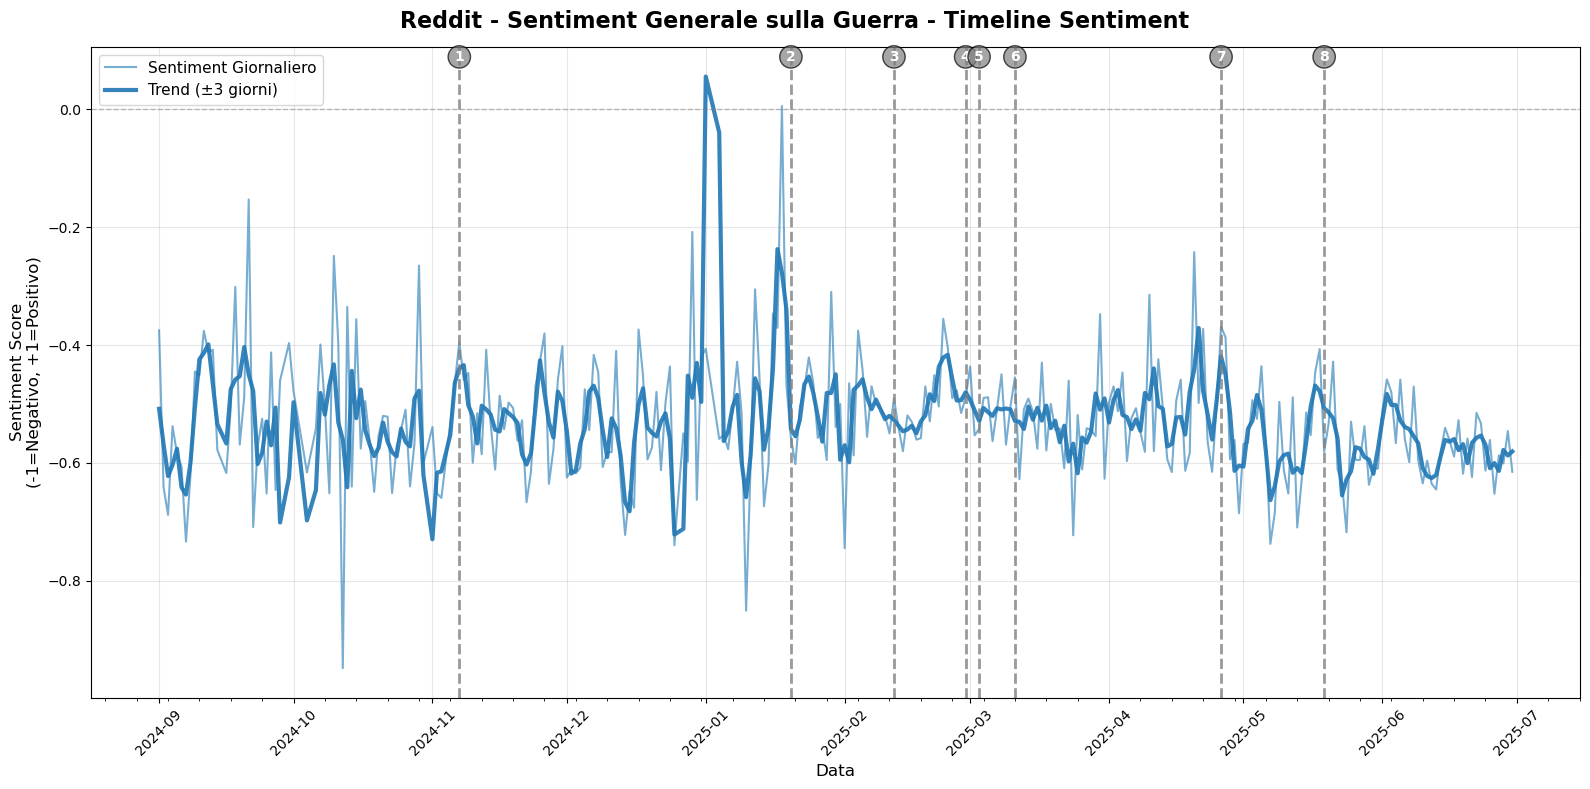


📈 ANALISI IMPATTO EVENTI - REDDIT - SENTIMENT GUERRA
   1) Elezione Trump (2024-11-07):
     Pre-evento:  -0.532 (17 commenti)     Post-evento: -0.427 (902 commenti)
     Variazione:  +0.105 📈 
   2) Insediamento Trump (2025-01-20):
     Pre-evento:  -0.343 (55 commenti)     Post-evento: -0.570 (546 commenti)
     Variazione:  -0.226 📉 *
   3) Trump telefona Putin (2025-02-12):
     Pre-evento:  -0.516 (550 commenti)     Post-evento: -0.537 (2155 commenti)
     Variazione:  -0.021 📉 
   4) Incontro Trump-Zelensky-Vance (2025-02-28):
     Pre-evento:  -0.485 (1176 commenti)     Post-evento: -0.474 (5688 commenti)
     Variazione:  +0.012 📈 
   5) Sospensione aiuti militari (2025-03-03):
     Pre-evento:  -0.461 (4938 commenti)     Post-evento: -0.508 (3283 commenti)
     Variazione:  -0.046 📉 *
   6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
     Pre-evento:  -0.527 (588 commenti)     Post-evento: -0.519 (1592 commenti)
     Variazione:  +0.008 📈 
   7) Incontro Trump-Zelensk

In [179]:
# GRAFICO 1: REDDIT - SENTIMENT GUERRA

print("🎯 GRAFICO 1: Reddit - Sentiment sulla Guerra")

if 'reddit_relevance' in locals() and not reddit_relevance.empty:
    # Prepara dati
    timeline_guerra_reddit = prepare_sentiment_timeline_data(
        reddit_relevance, 
        'comment_created_utc', 
        'sentiment_numeric'
    )
    
    # Crea grafico
    fig1, event_list = plot_single_sentiment_timeline(
        timeline_data=timeline_guerra_reddit,
        events_dict=key_events,
        date_column='comment_created_utc',
        sentiment_name='Sentiment Guerra',
        color='#1f77b4',
        title='Reddit - Sentiment Generale sulla Guerra',
        figsize=(16, 8)
    )
    
    plt.show()
    
    # Analisi impatto
    impact1 = analyze_single_sentiment_impact(
        df = reddit_relevance,
        events_dict = key_events, 
        date_column = 'comment_created_utc',
        sentiment_column = "sentiment_numeric", 
        sentiment_name = 'Reddit - Sentiment Guerra'
    )
    
else:
    print("❌ Dataset reddit_relevance non trovato")

🟠 GRAFICO 2: Reddit - Sentiment verso Trump
     ✓ 280 giorni con dati


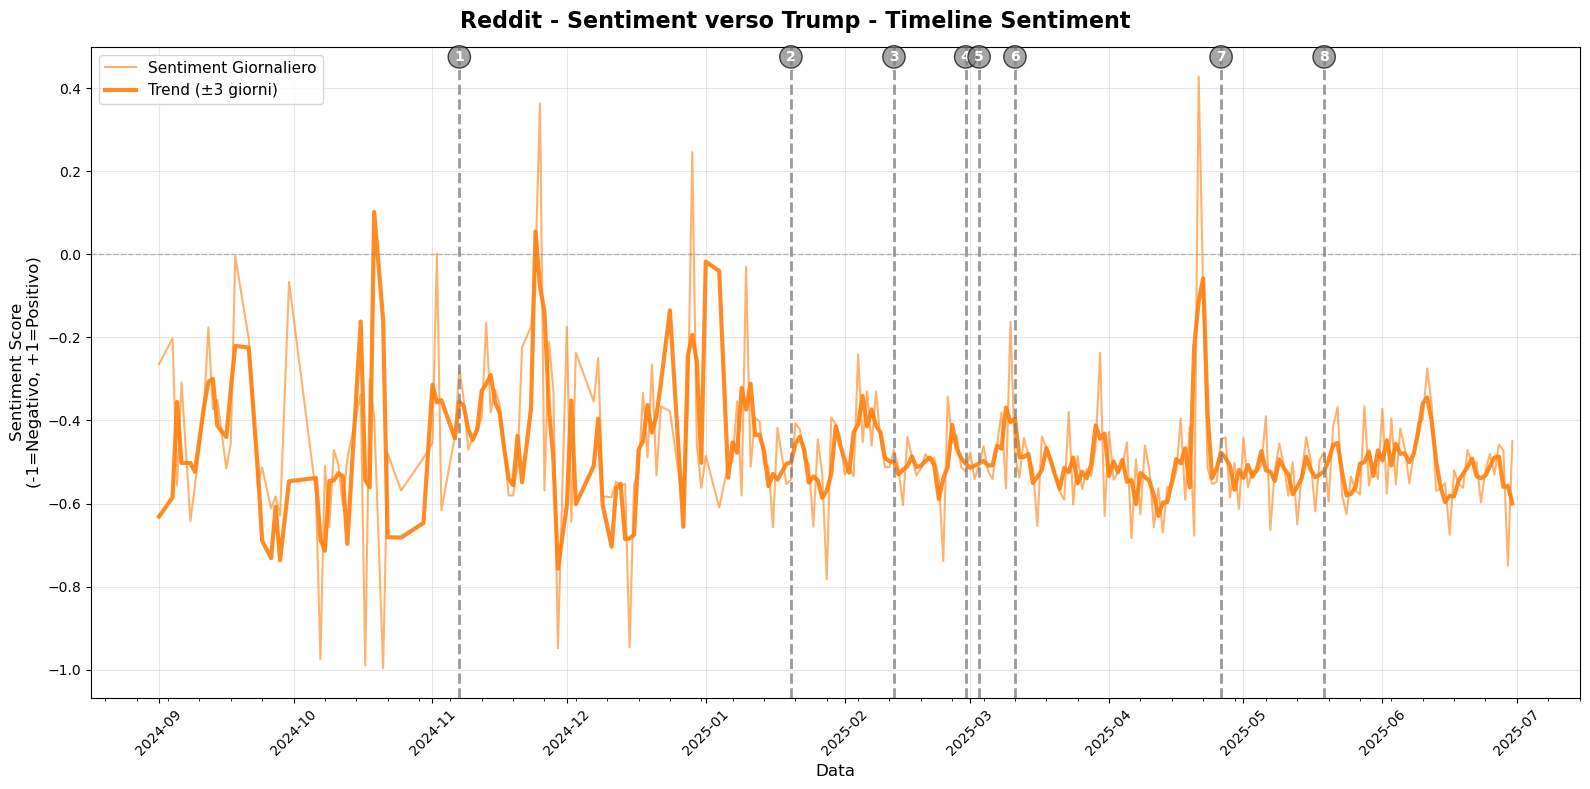


📈 ANALISI IMPATTO EVENTI - REDDIT - SENTIMENT TRUMP
   1) Elezione Trump (2024-11-07):
     ⚠ Dati insufficienti (Prima: 0, Dopo: 347)
   2) Insediamento Trump (2025-01-20):
     Pre-evento:  -0.418 (24 commenti)     Post-evento: -0.419 (369 commenti)
     Variazione:  -0.001 📉 
   3) Trump telefona Putin (2025-02-12):
     Pre-evento:  -0.500 (395 commenti)     Post-evento: -0.524 (994 commenti)
     Variazione:  -0.023 📉 
   4) Incontro Trump-Zelensky-Vance (2025-02-28):
     Pre-evento:  -0.448 (692 commenti)     Post-evento: -0.505 (3818 commenti)
     Variazione:  -0.057 📉 
   5) Sospensione aiuti militari (2025-03-03):
     Pre-evento:  -0.500 (3399 commenti)     Post-evento: -0.488 (1654 commenti)
     Variazione:  +0.012 📈 
   6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
     Pre-evento:  -0.486 (322 commenti)     Post-evento: -0.480 (813 commenti)
     Variazione:  +0.006 📈 
   7) Incontro Trump-Zelensky (funerale Papa) (2025-04-26):
     Pre-evento:  -0.535 (519 co

In [180]:
# GRAFICO 2: REDDIT - SENTIMENT TRUMP

print("🟠 GRAFICO 2: Reddit - Sentiment verso Trump")

if 'reddit_relevance' in locals() and not reddit_relevance.empty:
    # Prepara dati
    timeline_trump_reddit = prepare_sentiment_timeline_data(
        reddit_relevance, 
        'comment_created_utc', 
        'trump_sentiment'
    )
    
    # Crea grafico
    fig2, event_list = plot_single_sentiment_timeline(
        timeline_data=timeline_trump_reddit,
        events_dict=key_events,
        date_column='comment_created_utc',
        sentiment_name='Sentiment Trump',
        color='#ff7f0e',
        title='Reddit - Sentiment verso Trump',
        figsize=(16, 8)
    )
    
    plt.show()
    
    # Analisi impatto
    impact2 = analyze_single_sentiment_impact(
        df=reddit_relevance,                   
        events_dict=key_events, 
        date_column='comment_created_utc',
        sentiment_column='trump_sentiment',
        sentiment_name='Reddit - Sentiment Trump'
    )
    
else:
    print("❌ Dataset reddit_relevance non trovato")

🟡 GRAFICO 3: Reddit - Sentiment verso Zelensky
     ✓ 239 giorni con dati


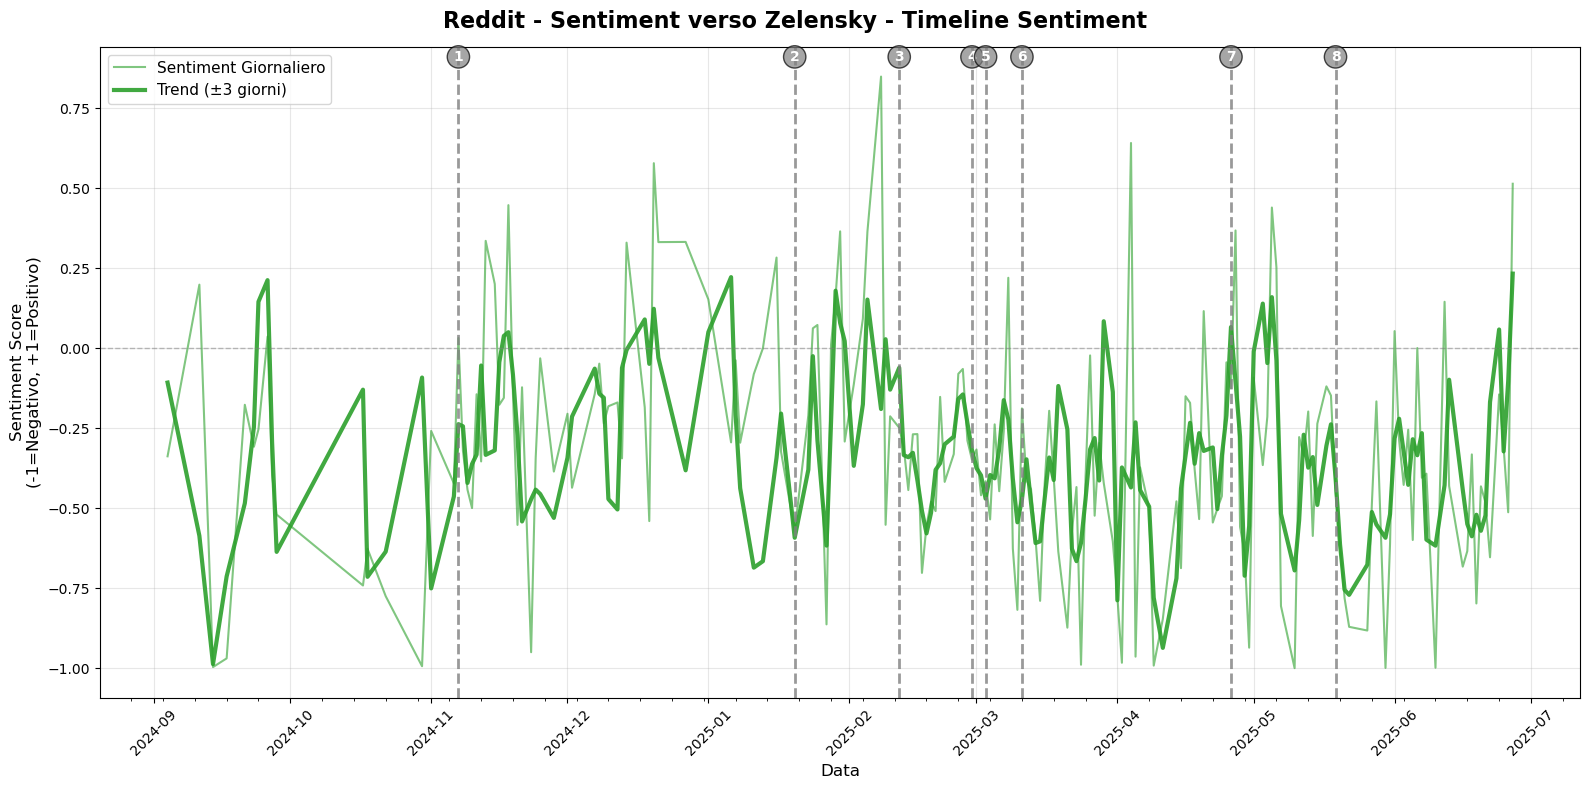


📈 ANALISI IMPATTO EVENTI - REDDIT - SENTIMENT ZELENSKY
   1) Elezione Trump (2024-11-07):
     ⚠ Dati insufficienti (Prima: 0, Dopo: 96)
   2) Insediamento Trump (2025-01-20):
     ⚠ Dati insufficienti (Prima: 3, Dopo: 25)
   3) Trump telefona Putin (2025-02-12):
     Pre-evento:  -0.306 (18 commenti)     Post-evento: -0.319 (166 commenti)
     Variazione:  -0.013 📉 
   4) Incontro Trump-Zelensky-Vance (2025-02-28):
     Pre-evento:  -0.074 (84 commenti)     Post-evento: -0.342 (1966 commenti)
     Variazione:  -0.268 📉 **
   5) Sospensione aiuti militari (2025-03-03):
     Pre-evento:  -0.331 (1803 commenti)     Post-evento: -0.416 (480 commenti)
     Variazione:  -0.085 📉 
   6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
     Pre-evento:  -0.267 (59 commenti)     Post-evento: -0.287 (93 commenti)
     Variazione:  -0.020 📉 
   7) Incontro Trump-Zelensky (funerale Papa) (2025-04-26):
     Pre-evento:  -0.479 (53 commenti)     Post-evento: -0.167 (116 commenti)
     Variazion

In [181]:
# GRAFICO 3: REDDIT - SENTIMENT ZELENSKY

print("🟡 GRAFICO 3: Reddit - Sentiment verso Zelensky")

if 'reddit_relevance' in locals() and not reddit_relevance.empty:
    # Prepara dati
    timeline_zelensky_reddit = prepare_sentiment_timeline_data(
        reddit_relevance, 
        'comment_created_utc', 
        'zelensky_sentiment'
    )
    
    # Crea grafico
    fig3, event_list = plot_single_sentiment_timeline(
        timeline_data=timeline_zelensky_reddit,
        events_dict=key_events,
        date_column='comment_created_utc',
        sentiment_name='Sentiment Zelensky',
        color='#2ca02c',
        title='Reddit - Sentiment verso Zelensky',
        figsize=(16, 8)
    )
    
    plt.show()
    
    # Analisi impatto
    impact3 = analyze_single_sentiment_impact(
        df=reddit_relevance,
        events_dict=key_events, 
        date_column='comment_created_utc',
        sentiment_column='zelensky_sentiment',
        sentiment_name='Reddit - Sentiment Zelensky'
    )

else:
    print("❌ Dataset reddit_relevance non trovato")

🕊️ GRAFICO 4: Reddit - Sentiment verso la Pace
     ✓ 264 giorni con dati


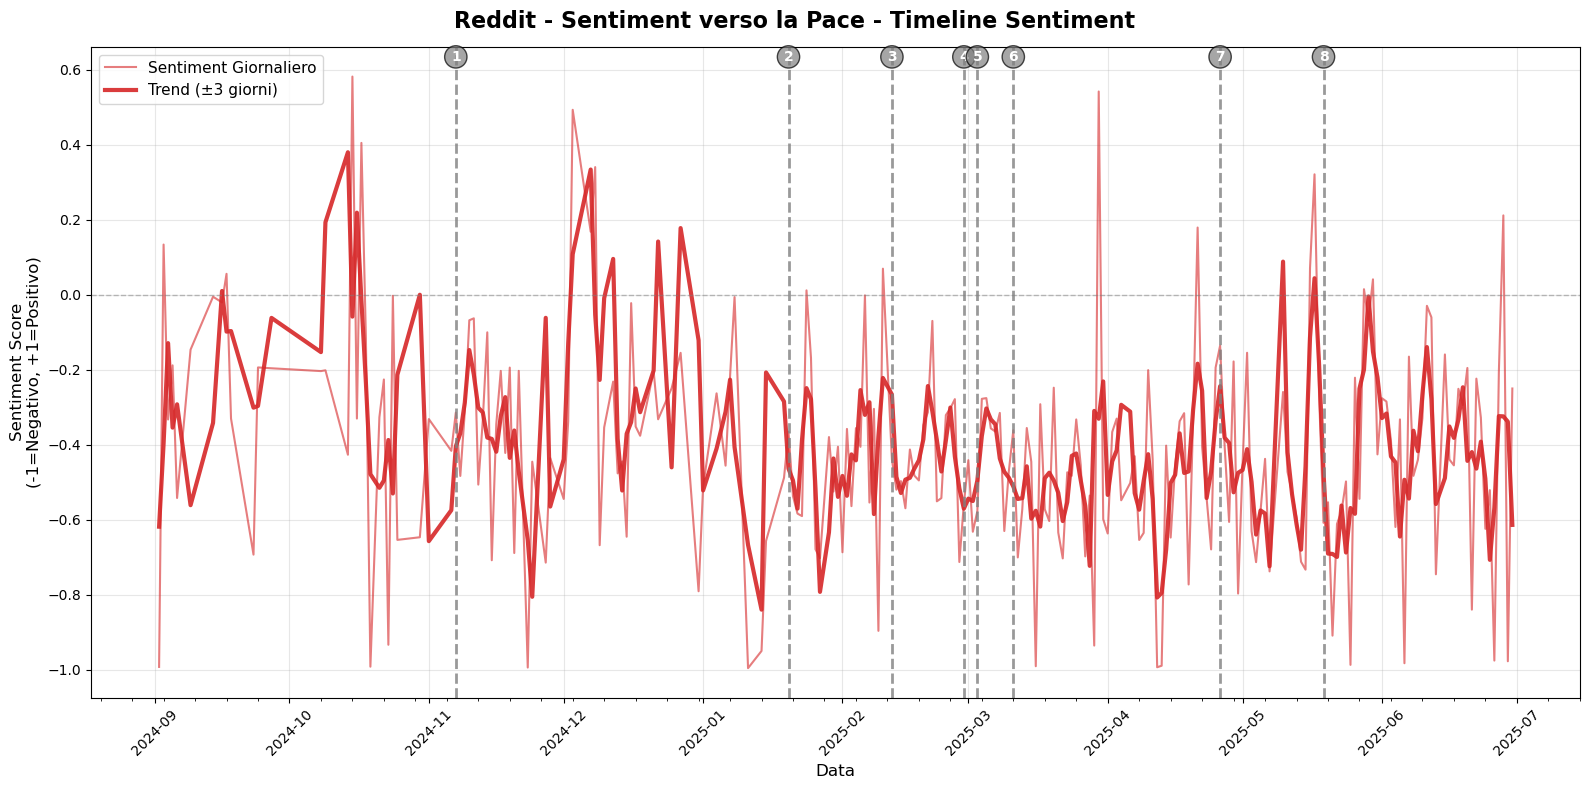


📈 ANALISI IMPATTO EVENTI - REDDIT - SENTIMENT PACE
   1) Elezione Trump (2024-11-07):
     ⚠ Dati insufficienti (Prima: 0, Dopo: 104)
   2) Insediamento Trump (2025-01-20):
     ⚠ Dati insufficienti (Prima: 2, Dopo: 53)
   3) Trump telefona Putin (2025-02-12):
     Pre-evento:  -0.199 (36 commenti)     Post-evento: -0.487 (202 commenti)
     Variazione:  -0.288 📉 
   4) Incontro Trump-Zelensky-Vance (2025-02-28):
     Pre-evento:  -0.294 (43 commenti)     Post-evento: -0.517 (458 commenti)
     Variazione:  -0.222 📉 
   5) Sospensione aiuti militari (2025-03-03):
     Pre-evento:  -0.494 (384 commenti)     Post-evento: -0.406 (306 commenti)
     Variazione:  +0.089 📈 
   6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
     Pre-evento:  -0.519 (65 commenti)     Post-evento: -0.531 (262 commenti)
     Variazione:  -0.012 📉 
   7) Incontro Trump-Zelensky (funerale Papa) (2025-04-26):
     Pre-evento:  -0.615 (111 commenti)     Post-evento: -0.451 (60 commenti)
     Variazione:  +0

In [182]:
# GRAFICO 4: REDDIT - SENTIMENT PEACE

print("🕊️ GRAFICO 4: Reddit - Sentiment verso la Pace")

if 'reddit_relevance' in locals() and not reddit_relevance.empty:
    # Prepara dati
    timeline_peace_reddit = prepare_sentiment_timeline_data(
        reddit_relevance, 
        'comment_created_utc', 
        'peace_sentiment'
    )
    
    # Crea grafico
    fig4, event_list = plot_single_sentiment_timeline(
        timeline_data=timeline_peace_reddit,
        events_dict=key_events,
        date_column='comment_created_utc',
        sentiment_name='Sentiment Peace',
        color='#d62728',
        title='Reddit - Sentiment verso la Pace',
        figsize=(16, 8)
    )
    
    plt.show()
    
    # Analisi impatto
    impact4 = analyze_single_sentiment_impact(
        df=reddit_relevance,
        events_dict=key_events, 
        date_column='comment_created_utc',
        sentiment_column='peace_sentiment',
        sentiment_name='Reddit - Sentiment Pace'
    )

else:
    print("❌ Dataset reddit_relevance non trovato")

🎯 GRAFICO 5: YouTube - Sentiment sulla Guerra
     ✓ 300 giorni con dati


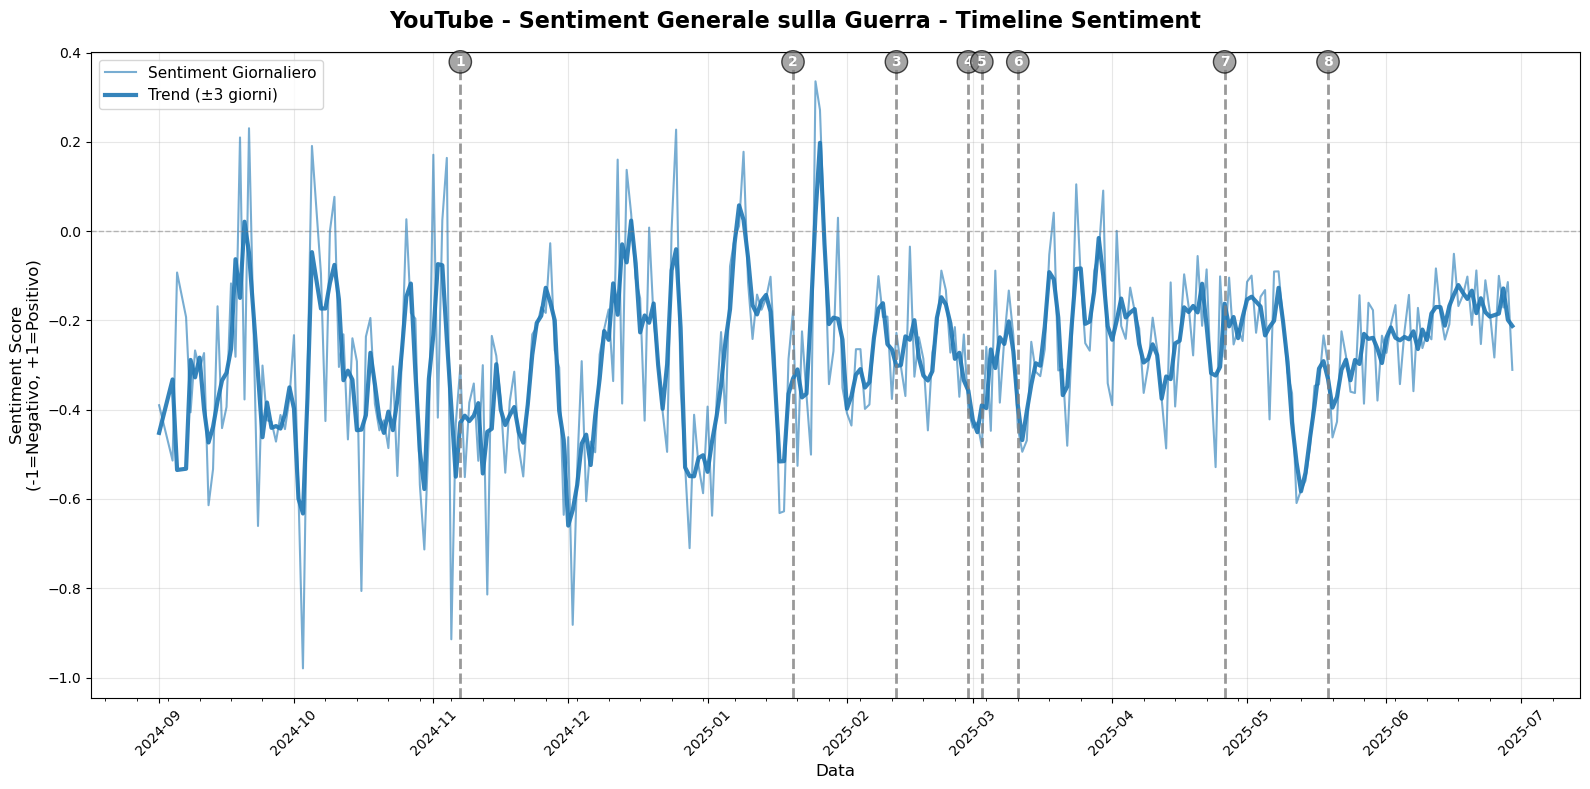


📈 ANALISI IMPATTO EVENTI - YOUTUBE - SENTIMENT GUERRA
   1) Elezione Trump (2024-11-07):
     Pre-evento:  -0.211 (23 commenti)     Post-evento: -0.405 (60 commenti)
     Variazione:  -0.194 📉 
   2) Insediamento Trump (2025-01-20):
     Pre-evento:  -0.629 (96 commenti)     Post-evento: -0.277 (90 commenti)
     Variazione:  +0.353 📈 **
   3) Trump telefona Putin (2025-02-12):
     Pre-evento:  -0.192 (332 commenti)     Post-evento: -0.292 (1425 commenti)
     Variazione:  -0.100 📉 
   4) Incontro Trump-Zelensky-Vance (2025-02-28):
     Pre-evento:  -0.288 (997 commenti)     Post-evento: -0.423 (18193 commenti)
     Variazione:  -0.135 📉 ***
   5) Sospensione aiuti militari (2025-03-03):
     Pre-evento:  -0.422 (16332 commenti)     Post-evento: -0.395 (2927 commenti)
     Variazione:  +0.027 📈 
   6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
     Pre-evento:  -0.208 (280 commenti)     Post-evento: -0.470 (270 commenti)
     Variazione:  -0.262 📉 ***
   7) Incontro Trump-Ze

In [183]:
# GRAFICO 5: YOUTUBE - SENTIMENT GUERRA

print("🎯 GRAFICO 5: YouTube - Sentiment sulla Guerra")

if 'youtube_data' in locals() and not youtube_data.empty:
    # Prepara dati
    timeline_guerra_youtube = prepare_sentiment_timeline_data(
        youtube_data, 
        'comment_published_at', 
        'sentiment_numeric'
    )
    
    # Crea grafico
    fig5, event_list = plot_single_sentiment_timeline(
        timeline_data=timeline_guerra_youtube,
        events_dict=key_events,
        date_column='comment_published_at',
        sentiment_name='Sentiment Guerra',
        color='#1f77b4',
        title='YouTube - Sentiment Generale sulla Guerra',
        figsize=(16, 8)
    )
    
    plt.show()
    
    # Analisi impatto
    impact5 = analyze_single_sentiment_impact(
        df=youtube_data,
        events_dict=key_events, 
        date_column='comment_published_at',
        sentiment_column='sentiment_numeric',
        sentiment_name='Youtube - Sentiment Guerra'
    )
    
else:
    print("❌ Dataset youtube_data non trovato")

🟠 GRAFICO 6: YouTube - Sentiment verso Trump
     ✓ 199 giorni con dati


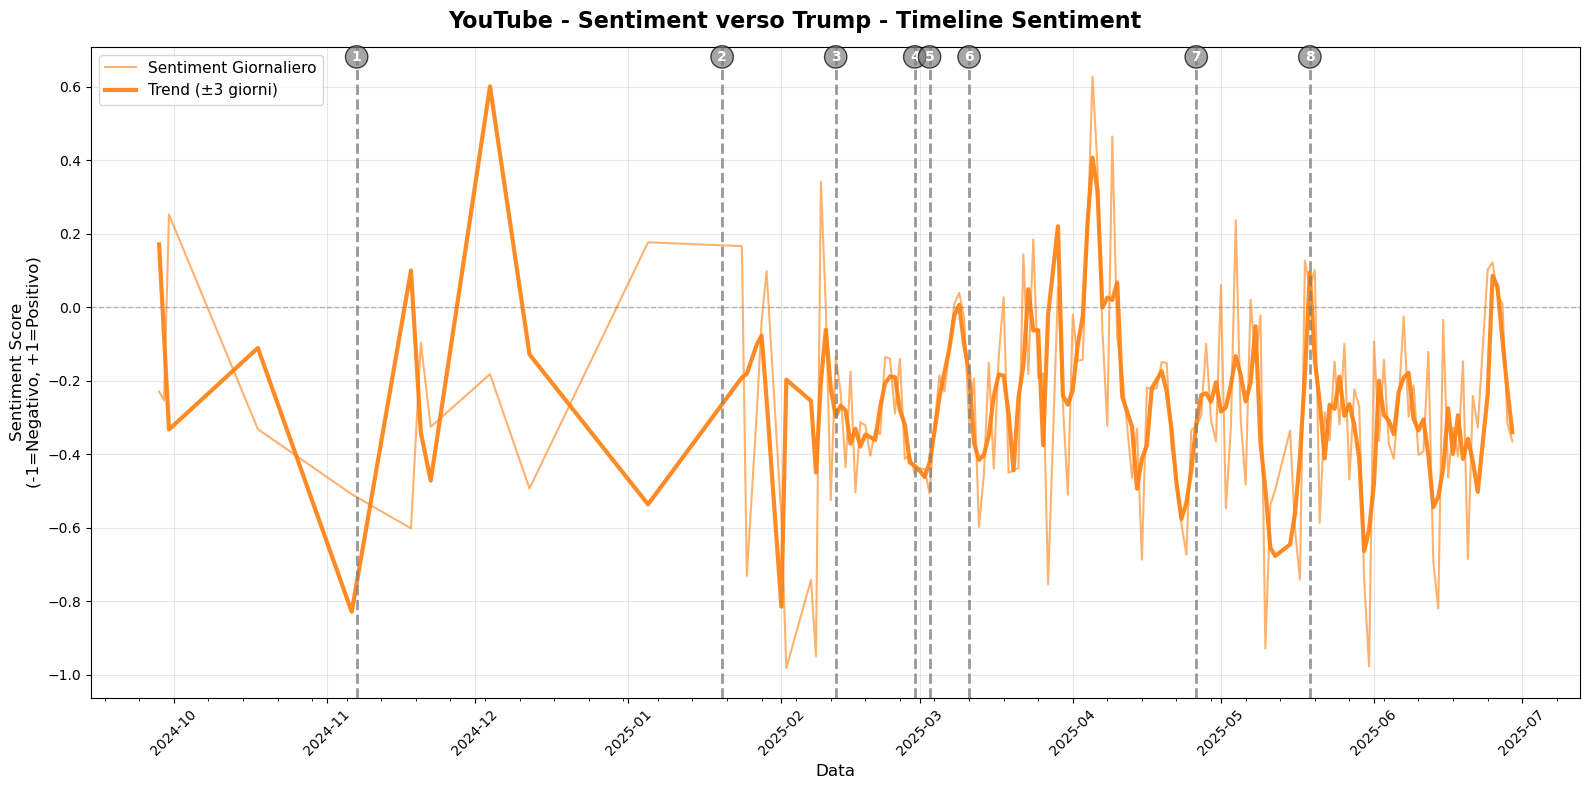


📈 ANALISI IMPATTO EVENTI - YOUTUBE - SENTIMENT TRUMP
   1) Elezione Trump (2024-11-07):
     ⚠ Dati insufficienti (Prima: 0, Dopo: 2)
   2) Insediamento Trump (2025-01-20):
     ⚠ Dati insufficienti (Prima: 0, Dopo: 3)
   3) Trump telefona Putin (2025-02-12):
     Pre-evento:  +0.113 (18 commenti)     Post-evento: -0.230 (348 commenti)
     Variazione:  -0.343 📉 
   4) Incontro Trump-Zelensky-Vance (2025-02-28):
     Pre-evento:  -0.204 (316 commenti)     Post-evento: -0.446 (9605 commenti)
     Variazione:  -0.241 📉 ***
   5) Sospensione aiuti militari (2025-03-03):
     Pre-evento:  -0.446 (8756 commenti)     Post-evento: -0.393 (1229 commenti)
     Variazione:  +0.053 📈 *
   6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
     Pre-evento:  +0.024 (88 commenti)     Post-evento: -0.461 (79 commenti)
     Variazione:  -0.485 📉 ***
   7) Incontro Trump-Zelensky (funerale Papa) (2025-04-26):
     Pre-evento:  -0.614 (116 commenti)     Post-evento: -0.305 (400 commenti)
     Varia

In [184]:
# GRAFICO 6: YOUTUBE - SENTIMENT TRUMP

print("🟠 GRAFICO 6: YouTube - Sentiment verso Trump")

if 'youtube_data' in locals() and not youtube_data.empty:
    # Prepara dati
    timeline_trump_youtube = prepare_sentiment_timeline_data(
        youtube_data, 
        'comment_published_at', 
        'trump_sentiment'
    )
    
    # Crea grafico
    fig6, event_list = plot_single_sentiment_timeline(
        timeline_data=timeline_trump_youtube,
        events_dict=key_events,
        date_column='comment_published_at',
        sentiment_name='Sentiment Trump',
        color='#ff7f0e',
        title='YouTube - Sentiment verso Trump',
        figsize=(16, 8)
    )
    
    plt.show()
    
    # Analisi impatto
    impact6 = analyze_single_sentiment_impact(
        df=youtube_data,
        events_dict=key_events, 
        date_column='comment_published_at',
        sentiment_column='trump_sentiment',
        sentiment_name='Youtube - Sentiment Trump'
    )
   
else:
    print("❌ Dataset youtube_data non trovato")

🟡 GRAFICO 7: YouTube - Sentiment verso Zelensky
     ✓ 213 giorni con dati


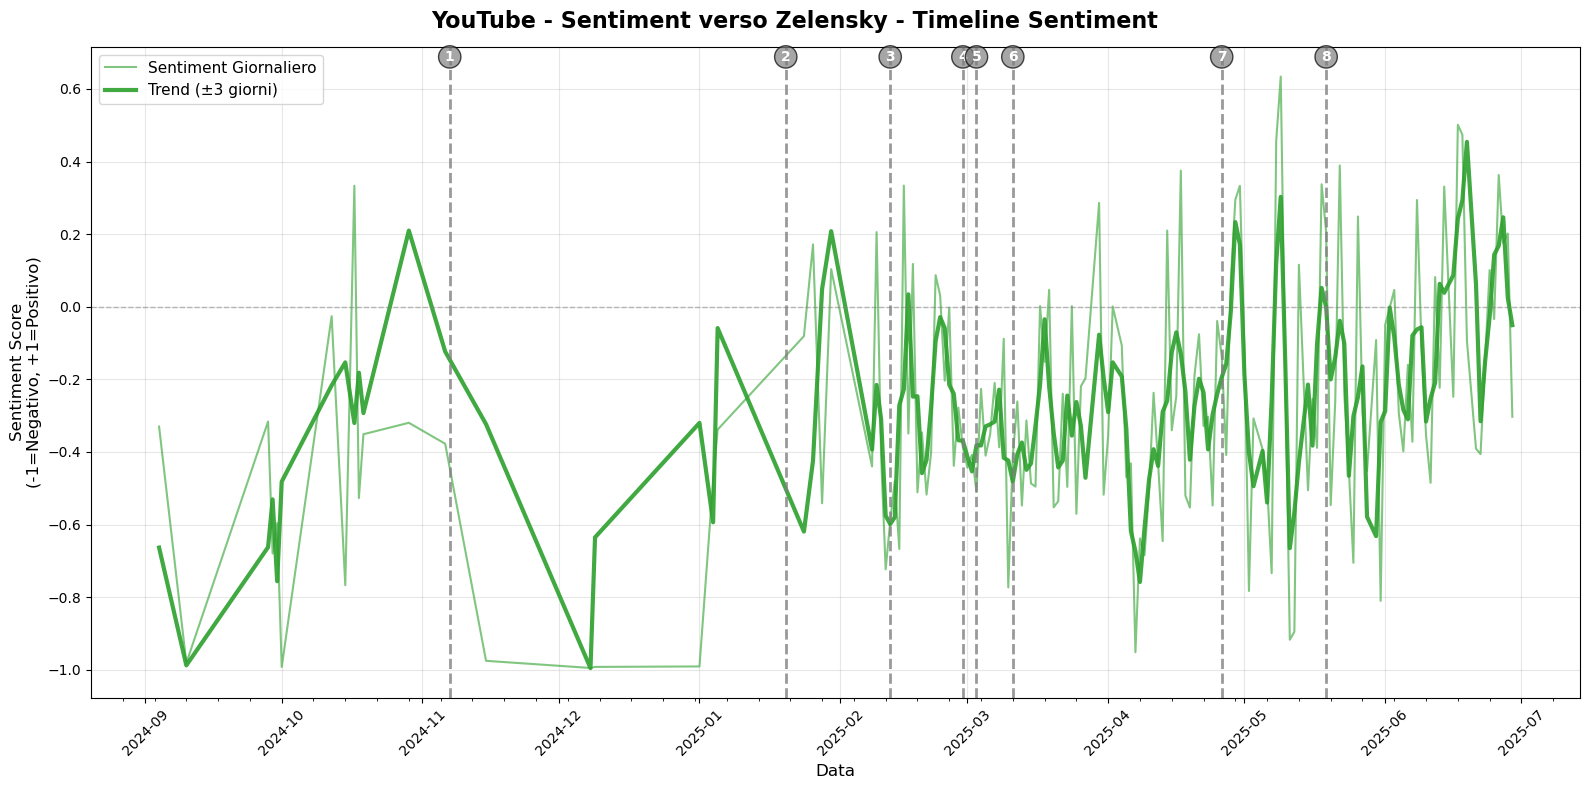


📈 ANALISI IMPATTO EVENTI - YOUTUBE - SENTIMENT ZELENSKY
   1) Elezione Trump (2024-11-07):
     ⚠ Dati insufficienti (Prima: 0, Dopo: 0)
   2) Insediamento Trump (2025-01-20):
     ⚠ Dati insufficienti (Prima: 0, Dopo: 3)
   3) Trump telefona Putin (2025-02-12):
     Pre-evento:  -0.000 (12 commenti)     Post-evento: -0.562 (100 commenti)
     Variazione:  -0.562 📉 *
   4) Incontro Trump-Zelensky-Vance (2025-02-28):
     Pre-evento:  -0.272 (63 commenti)     Post-evento: -0.416 (7939 commenti)
     Variazione:  -0.143 📉 
   5) Sospensione aiuti militari (2025-03-03):
     Pre-evento:  -0.416 (7232 commenti)     Post-evento: -0.400 (942 commenti)
     Variazione:  +0.017 📈 
   6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
     Pre-evento:  -0.297 (53 commenti)     Post-evento: -0.442 (67 commenti)
     Variazione:  -0.145 📉 
   7) Incontro Trump-Zelensky (funerale Papa) (2025-04-26):
     Pre-evento:  -0.483 (80 commenti)     Post-evento: -0.133 (239 commenti)
     Variazione:

In [185]:
# GRAFICO 7: YOUTUBE - SENTIMENT ZELENSKY

print("🟡 GRAFICO 7: YouTube - Sentiment verso Zelensky")

if 'youtube_data' in locals() and not youtube_data.empty:
    # Prepara dati
    timeline_zelensky_youtube = prepare_sentiment_timeline_data(
        youtube_data, 
        'comment_published_at', 
        'zelensky_sentiment'
    )
    
    # Crea grafico
    fig7, event_list = plot_single_sentiment_timeline(
        timeline_data=timeline_zelensky_youtube,
        events_dict=key_events,
        date_column='comment_published_at',
        sentiment_name='Sentiment Zelensky',
        color='#2ca02c',
        title='YouTube - Sentiment verso Zelensky',
        figsize=(16, 8)
    )
    
    plt.show()
    
    # Analisi impatto
    impact7 = analyze_single_sentiment_impact(
        df=youtube_data,
        events_dict=key_events, 
        date_column='comment_published_at',
        sentiment_column='zelensky_sentiment',
        sentiment_name='Youtube - Sentiment Zelensky'
    )

else:
    print("❌ Dataset youtube_data non trovato")

🕊️ GRAFICO 8: YouTube - Sentiment verso la Pace
     ✓ 250 giorni con dati


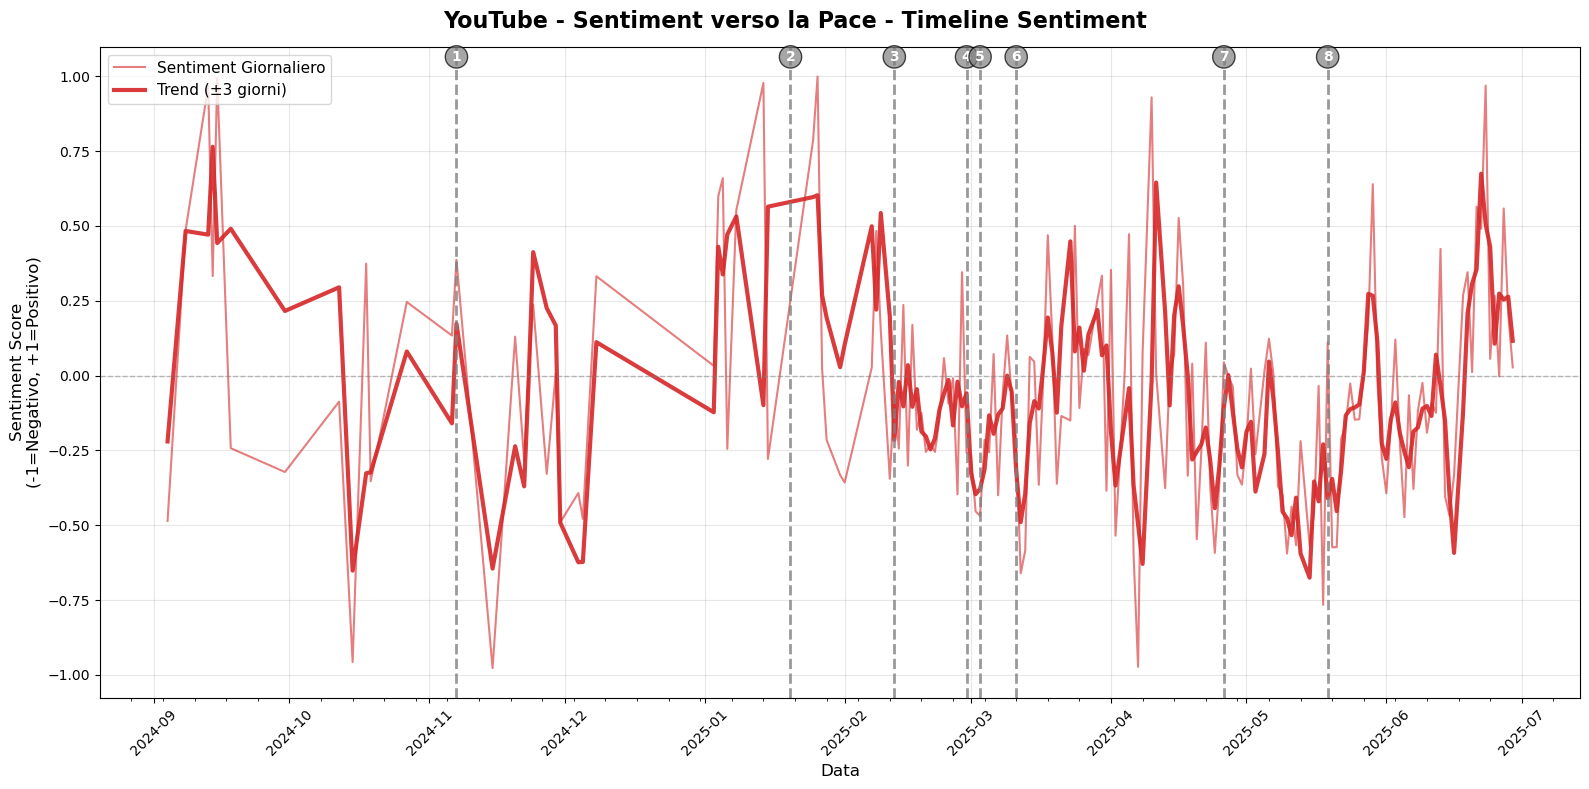


📈 ANALISI IMPATTO EVENTI - YOUTUBE - SENTIMENT PACE
   1) Elezione Trump (2024-11-07):
     ⚠ Dati insufficienti (Prima: 3, Dopo: 5)
   2) Insediamento Trump (2025-01-20):
     ⚠ Dati insufficienti (Prima: 1, Dopo: 2)
   3) Trump telefona Putin (2025-02-12):
     Pre-evento:  +0.338 (9 commenti)     Post-evento: -0.102 (155 commenti)
     Variazione:  -0.440 📉 
   4) Incontro Trump-Zelensky-Vance (2025-02-28):
     Pre-evento:  -0.193 (101 commenti)     Post-evento: -0.284 (1792 commenti)
     Variazione:  -0.090 📉 
   5) Sospensione aiuti militari (2025-03-03):
     Pre-evento:  -0.263 (1596 commenti)     Post-evento: -0.328 (302 commenti)
     Variazione:  -0.065 📉 
   6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
     Pre-evento:  -0.011 (26 commenti)     Post-evento: -0.563 (41 commenti)
     Variazione:  -0.552 📉 *
   7) Incontro Trump-Zelensky (funerale Papa) (2025-04-26):
     Pre-evento:  -0.493 (57 commenti)     Post-evento: +0.033 (77 commenti)
     Variazione:  +0.

In [186]:
# GRAFICO 8: YOUTUBE - SENTIMENT PEACE

print("🕊️ GRAFICO 8: YouTube - Sentiment verso la Pace")

if 'youtube_data' in locals() and not youtube_data.empty:
    # Prepara dati
    timeline_peace_youtube = prepare_sentiment_timeline_data(
        youtube_data, 
        'comment_published_at', 
        'peace_sentiment'
    )
    
    # Crea grafico
    fig8, event_list = plot_single_sentiment_timeline(
        timeline_data=timeline_peace_youtube,
        events_dict=key_events,
        date_column='comment_published_at',
        sentiment_name='Sentiment Peace',
        color='#d62728',
        title='YouTube - Sentiment verso la Pace',
        figsize=(16, 8)
    )
    
    plt.show()
    
    # Analisi impatto
    impact8 = analyze_single_sentiment_impact(
        df=youtube_data,
        events_dict=key_events, 
        date_column='comment_published_at',
        sentiment_column='peace_sentiment',
        sentiment_name='Youtube - Sentiment Pace'
    )
    
else:
    print("❌ Dataset youtube_data non trovato")

**Grafico**: Mostra medie giornaliere, se un giorno ha pochi commenti molto negativi e un altro giorno ha molti commenti meno negativi, la media giornaliera può essere fuorviante.

**Analisi numerica**:Calcola la media di TUTTI i commenti individuali → più accurata statisticamente

Proviamo con boxplot.

In [167]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns

def create_event_boxplot_data(df, events_dict, date_column, sentiment_column, window_days=3):
    """
    Prepara i dati per il boxplot degli eventi
    
    Args:
        df: DataFrame con i dati
        events_dict: Dict con eventi
        date_column: Nome colonna data
        sentiment_column: Nome colonna sentiment
        window_days: Giorni finestra (default: 3)
    
    Returns:
        DataFrame con dati strutturati per boxplot
    """
    # Prepara dati
    df = df.copy()
    df[sentiment_column] = pd.to_numeric(df[sentiment_column], errors='coerce')
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Rimuovi timezone se presente
    if hasattr(df[date_column].dtype, 'tz') and df[date_column].dt.tz is not None:
        df[date_column] = df[date_column].dt.tz_localize(None)
    
    valid_data = df[df[sentiment_column].notna()].copy()
    
    all_data = []
    
    for event_name, event_date_str in events_dict.items():
        event_date = pd.to_datetime(event_date_str)
        
        # Finestre (allineate con l'analisi corretta)
        before_start = event_date - timedelta(days=window_days)
        before_end = event_date - timedelta(days=1)
        after_start = event_date
        after_end = event_date + timedelta(days=window_days)
        
        # Filtra dati prima dell'evento
        before_data = valid_data[
            (valid_data[date_column] >= before_start) & 
            (valid_data[date_column] <= before_end)
        ]
        
        # Filtra dati dopo l'evento
        after_data = valid_data[
            (valid_data[date_column] >= after_start) & 
            (valid_data[date_column] <= after_end)
        ]
        
        # Aggiungi dati "prima" se sufficienti
        if len(before_data) >= 5:
            for sentiment_value in before_data[sentiment_column]:
                all_data.append({
                    'event': event_name,
                    'event_date': event_date_str,
                    'period': 'Prima (-3/-1 gg)',
                    'sentiment': sentiment_value,
                    'count_before': len(before_data),
                    'count_after': len(after_data)
                })
        
        # Aggiungi dati "dopo" se sufficienti
        if len(after_data) >= 5:
            for sentiment_value in after_data[sentiment_column]:
                all_data.append({
                    'event': event_name,
                    'event_date': event_date_str,
                    'period': 'Dopo (0/+3 gg)',
                    'sentiment': sentiment_value,
                    'count_before': len(before_data),
                    'count_after': len(after_data)
                })
    
    return pd.DataFrame(all_data)


def plot_events_boxplot(boxplot_data, title="Analisi Eventi - Prima vs Dopo", figsize=(20, 12)):
    """
    Crea boxplot per ogni evento confrontando prima/dopo
    
    Args:
        boxplot_data: DataFrame preparato con create_event_boxplot_data
        title: Titolo del grafico
        figsize: Dimensioni figura
    
    Returns:
        Figura matplotlib
    """
    if boxplot_data.empty:
        print("❌ Nessun dato disponibile per il boxplot")
        return None
    
    # Conta eventi unici con dati sufficienti
    events_with_data = boxplot_data['event'].unique()
    n_events = len(events_with_data)
    
    if n_events == 0:
        print("❌ Nessun evento con dati sufficienti")
        return None
    
    # Calcola layout griglia (max 3 colonne)
    cols = min(3, n_events)
    rows = (n_events + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    # Se solo un subplot, converti in array
    if n_events == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if hasattr(axes, '__iter__') else [axes]
    else:
        axes = axes.flatten()
    
    # Colori per prima/dopo
    colors = ['lightcoral', 'lightblue']
    
    for i, event in enumerate(events_with_data):
        ax = axes[i]
        
        # Filtra dati per questo evento
        event_data = boxplot_data[boxplot_data['event'] == event]
        
        if event_data.empty:
            ax.text(0.5, 0.5, 'Dati insufficienti', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(event, fontsize=12, pad=10)
            continue
        
        # Crea boxplot
        bp = ax.boxplot([
            event_data[event_data['period'] == 'Prima (-3/-1 gg)']['sentiment'].values,
            event_data[event_data['period'] == 'Dopo (0/+3 gg)']['sentiment'].values
        ], 
        labels=['Prima\n(-3/-1 gg)', 'Dopo\n(0/+3 gg)'],
        patch_artist=True,
        showfliers=True,  # Mostra outliers
        flierprops=dict(marker='o', markersize=4, alpha=0.6))
        
        # Colora le box
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Calcola statistiche per questo evento
        before_data = event_data[event_data['period'] == 'Prima (-3/-1 gg)']['sentiment']
        after_data = event_data[event_data['period'] == 'Dopo (0/+3 gg)']['sentiment']
        
        if len(before_data) > 0 and len(after_data) > 0:
            before_mean = before_data.mean()
            after_mean = after_data.mean()
            change = after_mean - before_mean
            
            # Test statistico
            from scipy.stats import ttest_ind
            try:
                t_stat, p_value = ttest_ind(before_data, after_data)
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "n.s."
            except:
                p_value, significance = None, "N/A"
            
            # Aggiungi linee delle medie
            ax.axhline(before_mean, xmin=0.05, xmax=0.45, color='red', linestyle='--', alpha=0.8, linewidth=2)
            ax.axhline(after_mean, xmin=0.55, xmax=0.95, color='blue', linestyle='--', alpha=0.8, linewidth=2)
            
            # Info nell'angolo
            info_text = f"Δ: {change:+.3f}\np: {p_value:.3f} {significance}" if p_value else f"Δ: {change:+.3f}"
            ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                   fontsize=9, verticalalignment='top')
            
            # Conta commenti
            n_before = len(before_data)
            n_after = len(after_data)
            count_text = f"n₁={n_before}\nn₂={n_after}"
            ax.text(0.98, 0.02, count_text, transform=ax.transAxes,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8),
                   fontsize=9, horizontalalignment='right', verticalalignment='bottom')
        
        # Configurazione asse
        ax.set_ylabel('Sentiment Score', fontsize=10)
        ax.set_title(f"{event}\n({event_data['event_date'].iloc[0]})", fontsize=11, pad=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1.1, 1.1)  # Range fisso per confronto
        
        # Linea dello zero
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
    
    # Rimuovi assi extra se necessario
    for j in range(n_events, len(axes)):
        axes[j].remove()
    
    plt.tight_layout()
    return fig


def create_summary_stats_table(boxplot_data):
    """
    Crea tabella riassuntiva delle statistiche per evento
    
    Args:
        boxplot_data: DataFrame con i dati del boxplot
    
    Returns:
        DataFrame con statistiche riassuntive
    """
    summary_stats = []
    
    for event in boxplot_data['event'].unique():
        event_data = boxplot_data[boxplot_data['event'] == event]
        
        before_data = event_data[event_data['period'] == 'Prima (-3/-1 gg)']['sentiment']
        after_data = event_data[event_data['period'] == 'Dopo (0/+3 gg)']['sentiment']
        
        if len(before_data) >= 5 and len(after_data) >= 5:
            before_mean = before_data.mean()
            after_mean = after_data.mean()
            change = after_mean - before_mean
            
            # Test statistico
            from scipy.stats import ttest_ind
            try:
                t_stat, p_value = ttest_ind(before_data, after_data)
                significant = p_value < 0.05
            except:
                p_value, significant = None, False
            
            summary_stats.append({
                'Evento': event,
                'Data': event_data['event_date'].iloc[0],
                'Prima_Media': before_mean,
                'Prima_N': len(before_data),
                'Dopo_Media': after_mean,
                'Dopo_N': len(after_data),
                'Variazione': change,
                'P_Value': p_value,
                'Significativo': significant
            })
    
    return pd.DataFrame(summary_stats)


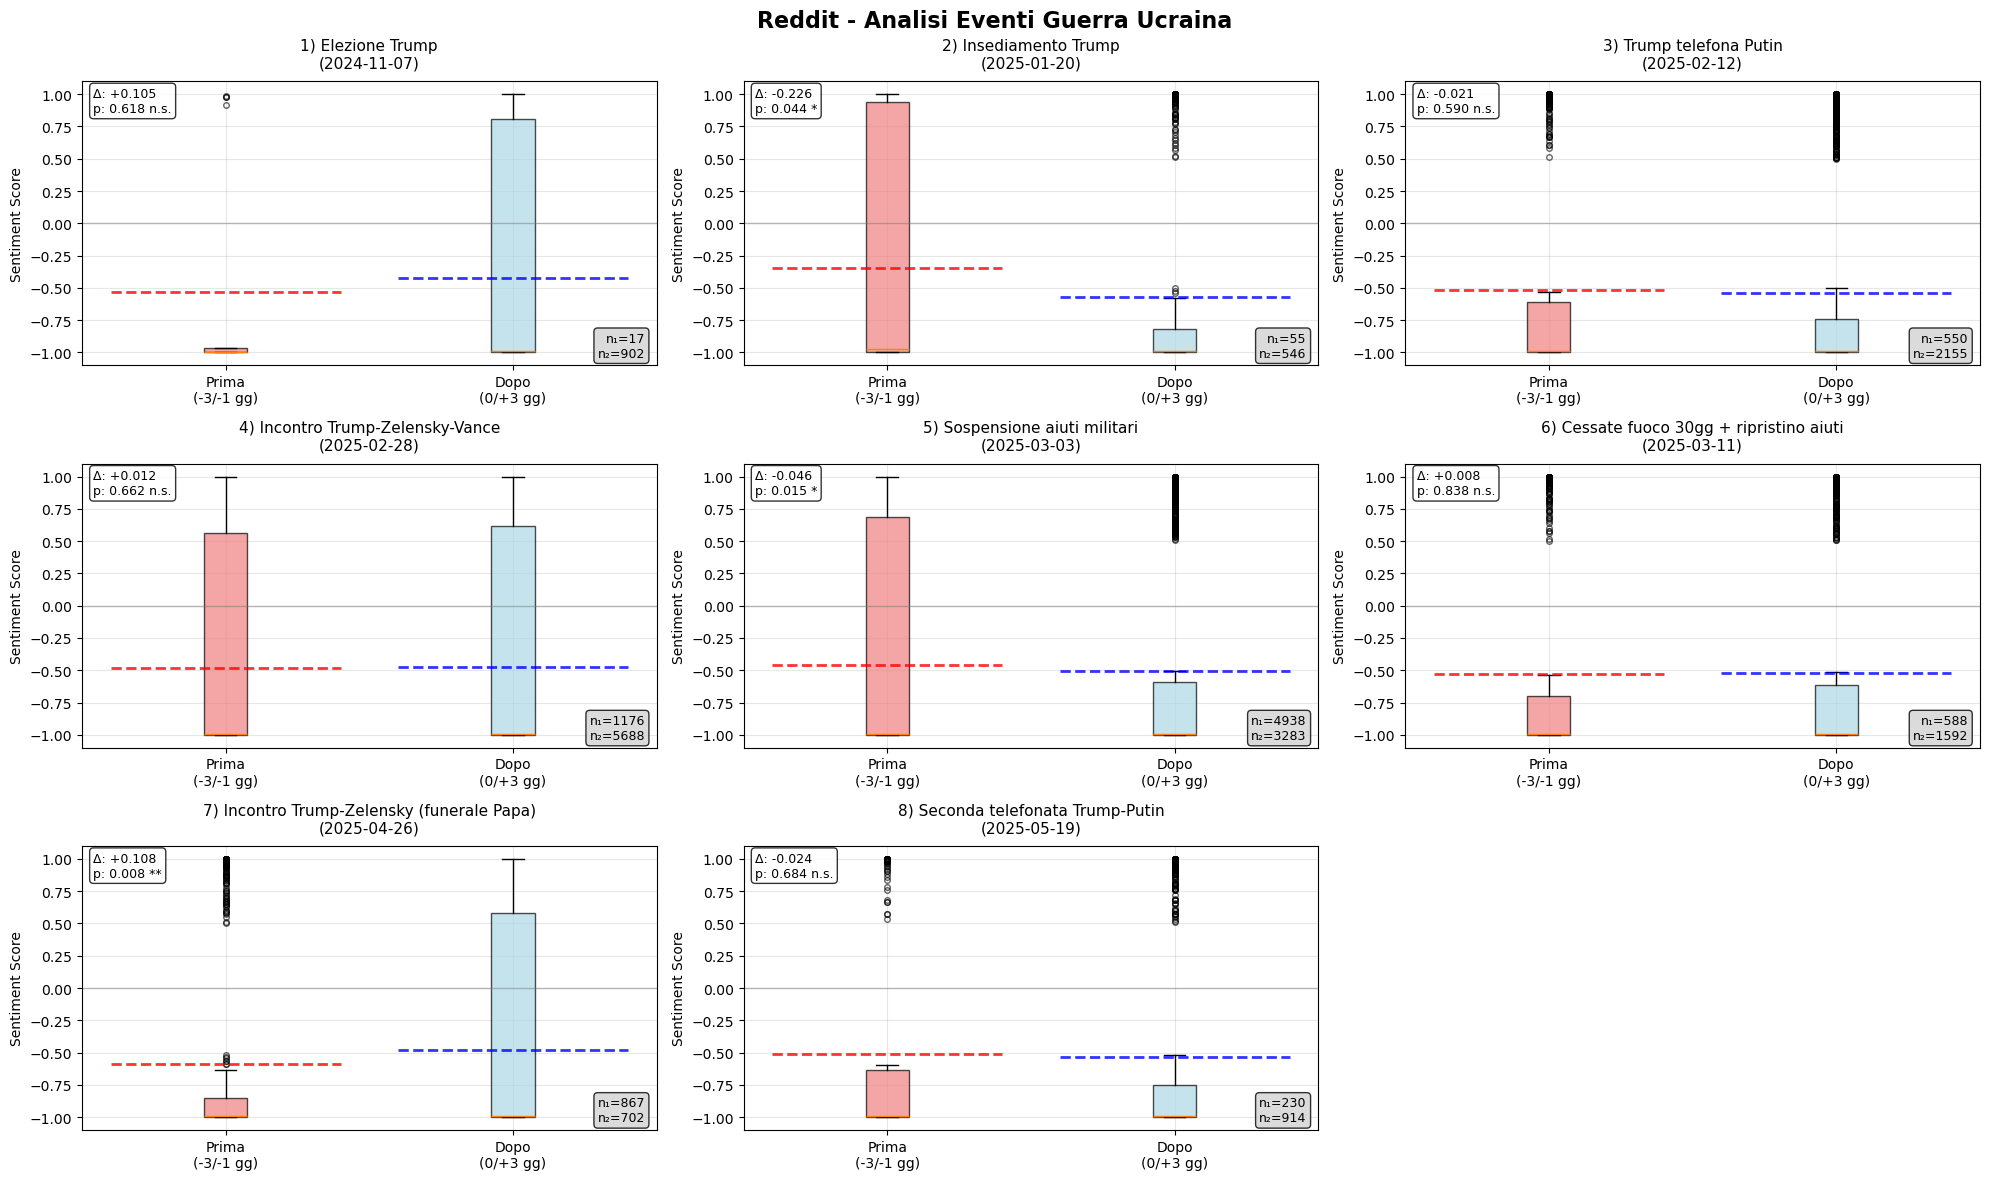

                                       Evento        Data  Prima_Media  \
0                           1) Elezione Trump  2024-11-07    -0.532250   
1                       2) Insediamento Trump  2025-01-20    -0.343404   
2                     3) Trump telefona Putin  2025-02-12    -0.516195   
3            4) Incontro Trump-Zelensky-Vance  2025-02-28    -0.485340   
4               5) Sospensione aiuti militari  2025-03-03    -0.461440   
5    6) Cessate fuoco 30gg + ripristino aiuti  2025-03-11    -0.526882   
6  7) Incontro Trump-Zelensky (funerale Papa)  2025-04-26    -0.589967   
7           8) Seconda telefonata Trump-Putin  2025-05-19    -0.510304   

   Prima_N  Dopo_Media  Dopo_N  Variazione   P_Value  Significativo  
0       17   -0.426801     902    0.105448  0.618006          False  
1       55   -0.569693     546   -0.226289  0.044343           True  
2      550   -0.536897    2155   -0.020702  0.590495          False  
3     1176   -0.473567    5688    0.011772  0.662104 

In [168]:
# Usa il tuo DataFrame Reddit
boxplot_data = create_event_boxplot_data(
    df=reddit_relevance, 
    events_dict=key_events,
    date_column='comment_created_utc',
    sentiment_column='sentiment_numeric'
)

# Crea il grafico
fig = plot_events_boxplot(boxplot_data, title="Reddit - Analisi Eventi Guerra Ucraina")
plt.show()

# Tabella riassuntiva
summary = create_summary_stats_table(boxplot_data)
print(summary)

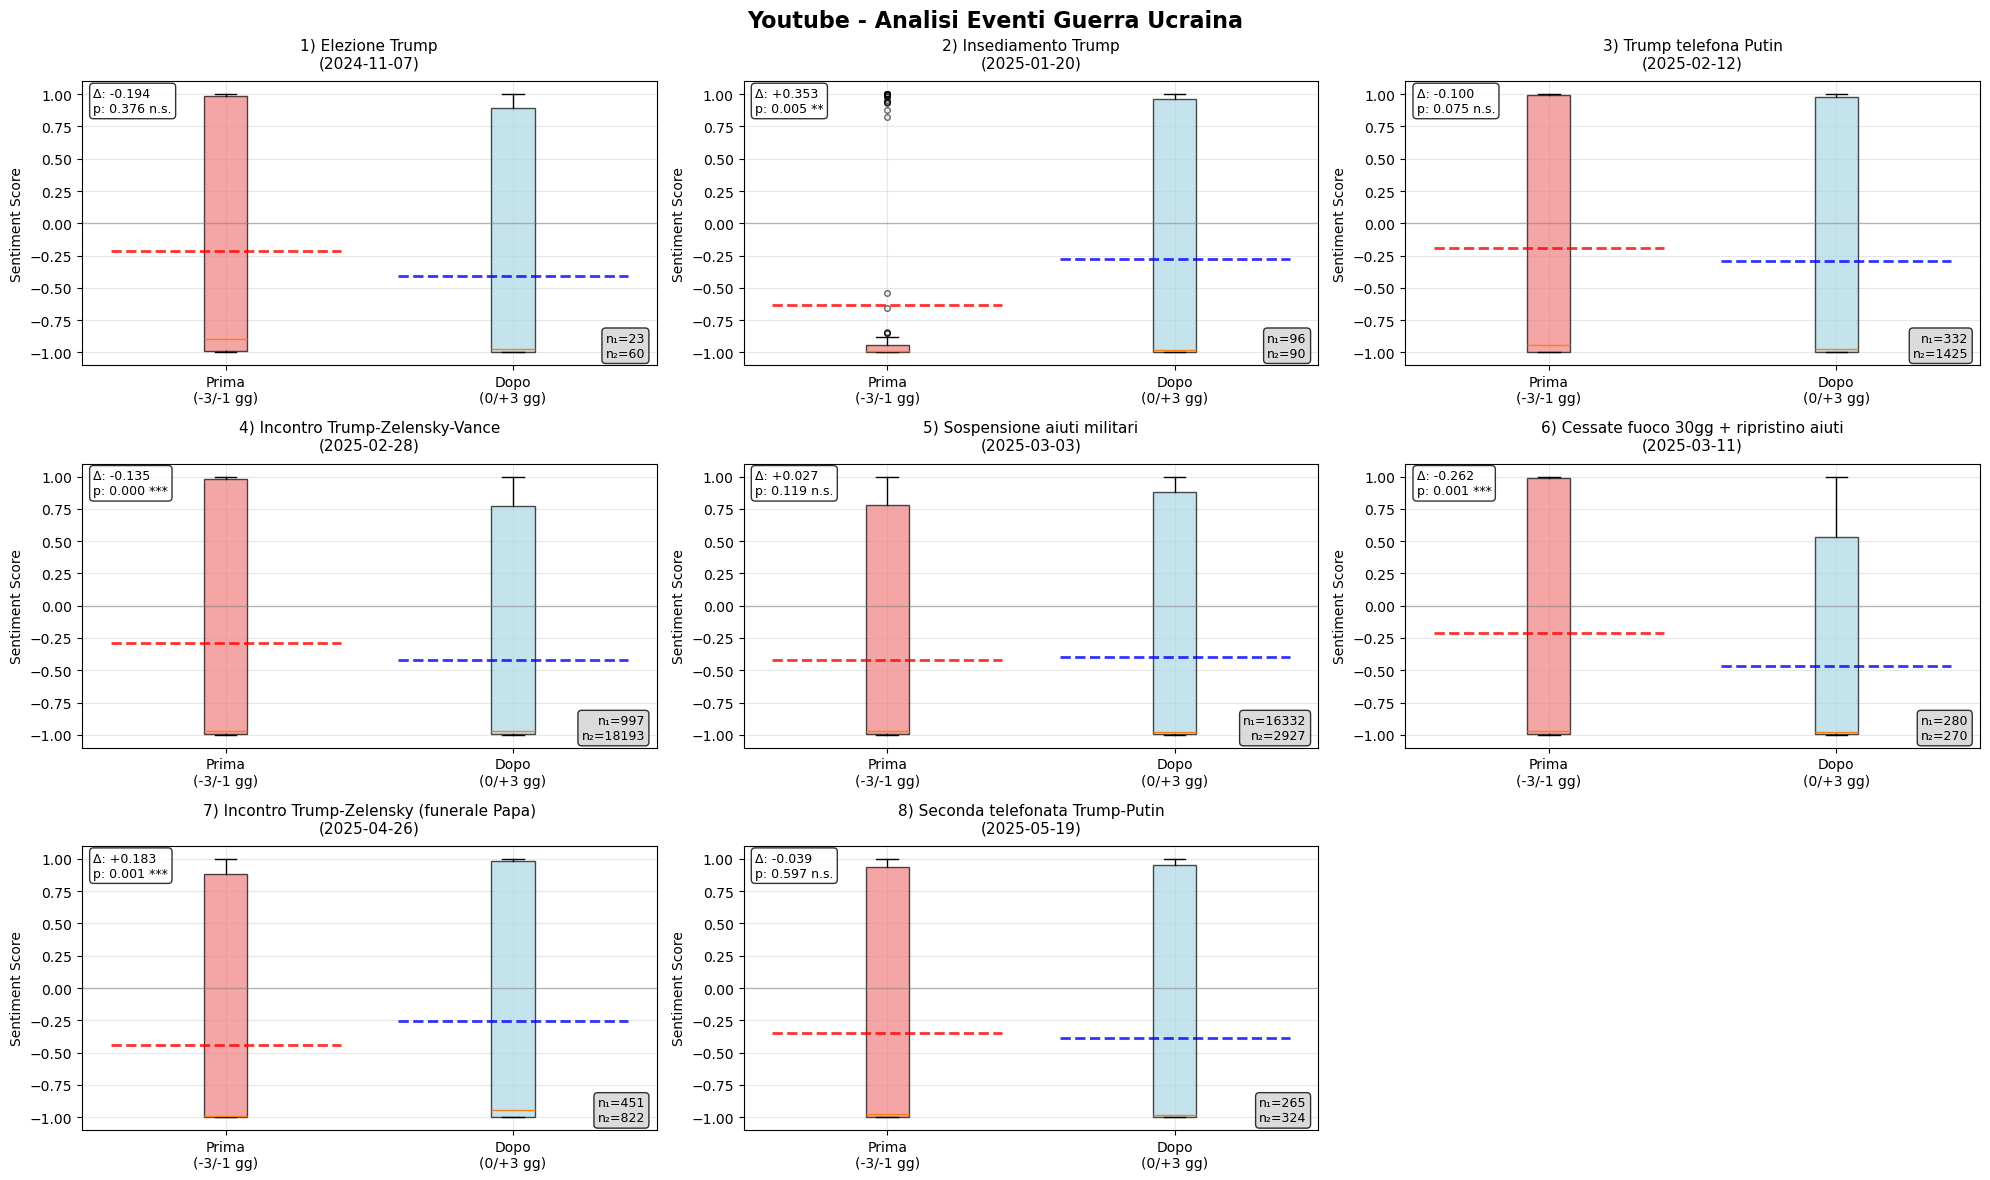

                                       Evento        Data  Prima_Media  \
0                           1) Elezione Trump  2024-11-07    -0.211074   
1                       2) Insediamento Trump  2025-01-20    -0.629448   
2                     3) Trump telefona Putin  2025-02-12    -0.191986   
3            4) Incontro Trump-Zelensky-Vance  2025-02-28    -0.287643   
4               5) Sospensione aiuti militari  2025-03-03    -0.421924   
5    6) Cessate fuoco 30gg + ripristino aiuti  2025-03-11    -0.207865   
6  7) Incontro Trump-Zelensky (funerale Papa)  2025-04-26    -0.438060   
7           8) Seconda telefonata Trump-Putin  2025-05-19    -0.344794   

   Prima_N  Dopo_Media  Dopo_N  Variazione   P_Value  Significativo  
0       23   -0.405367      60   -0.194293  0.376129          False  
1       96   -0.276805      90    0.352643  0.004606           True  
2      332   -0.292268    1425   -0.100282  0.075190          False  
3      997   -0.422596   18193   -0.134953  0.000001 

In [ ]:
# Usa il tuo DataFrame youtube
boxplot_data = create_event_boxplot_data(
    df=youtube_data, 
    events_dict=key_events,
    date_column='comment_published_at',
    sentiment_column='sentiment_numeric'
)

# Crea il grafico
fig = plot_events_boxplot(boxplot_data, title="Youtube - Analisi Eventi Guerra Ucraina")
plt.show()

# Tabella riassuntiva
summary = create_summary_stats_table(boxplot_data)
print(summary)

## 9. Salvataggio dei Risultati

In [172]:
import os

# Crea cartella results se non esiste
os.makedirs('results', exist_ok=True)

# Salva i dataset processati con sentiment
print("💾 Salvando i risultati...")

# Salva dataset completi
# if not reddit_all.empty:
#     reddit_all.to_csv('results/reddit_all_with_sentiment.csv', index=False)
#     print("✓ Reddit ALL salvato")

if not reddit_relevance.empty:
    reddit_relevance.to_csv('results/reddit_relevance_with_sentiment.csv', index=False)
    print("✓ Reddit RELEVANCE salvato")

if not youtube_data.empty:
    youtube_data.to_csv('results/youtube_with_sentiment.csv', index=False)
    print("✓ YouTube salvato")

# Salva timeline giornaliere
for name, timeline_data in timeline_results.items():
    if timeline_data is not None:
        timeline_data.to_csv(f'results/{name}_daily_timeline.csv', index=False)
        print(f"✓ Timeline {name} salvata")

print("\n🎉 DATI SALVATI!")
print("📁 Tutti i file sono stati salvati nella cartella 'results/'")

💾 Salvando i risultati...
✓ Reddit RELEVANCE salvato
✓ YouTube salvato
✓ Timeline df salvata

🎉 DATI SALVATI!
📁 Tutti i file sono stati salvati nella cartella 'results/'


## 10. Analisi Statistica degli Eventi

In [173]:
def analyze_events_simple(df, dataset_name):
    """Analisi semplice degli eventi con statistiche descrittive"""
    if df.empty:
        print(f"❌ {dataset_name}: Dataset vuoto")
        return None
    
    date_col = 'comment_created_utc' if 'comment_created_utc' in df.columns else 'comment_published_at'
    if date_col not in df.columns:
        print(f"❌ {dataset_name}: Colonna data non trovata")
        return None
    
    # Filtra solo commenti con sentiment calcolato (keywords guerra)
    sentiment_comments = df.dropna(subset=['sentiment_numeric'])
    
    if sentiment_comments.empty:
        print(f"❌ {dataset_name}: Nessun commento con sentiment")
        return None
    
    print(f"\n📊 ANALISI EVENTI - {dataset_name}")
    print("=" * 50)
    
    results = []
    
    for event_name, event_date_str in key_events.items():
        event_date = pd.to_datetime(event_date_str).tz_localize(None)
        
        # Finestra di 3 giorni prima e dopo
        before_start = event_date - timedelta(days=3)
        before_end = event_date - timedelta(days=1)
        after_start = event_date
        after_end = event_date + timedelta(days=3)
        
        # Filtra commenti
        before_comments = sentiment_comments[
            (sentiment_comments[date_col] >= before_start) & 
            (sentiment_comments[date_col] <= before_end)
        ]
        
        after_comments = sentiment_comments[
            (sentiment_comments[date_col] >= after_start) & 
            (sentiment_comments[date_col] <= after_end)
        ]
        
        if len(before_comments) < 5 or len(after_comments) < 5:
            print(f"⚠️ {event_name}: Dati insufficienti")
            continue
        
        # Calcola statistiche
        sentiment_before = before_comments['sentiment_numeric'].mean()
        sentiment_after = after_comments['sentiment_numeric'].mean()
        change = sentiment_after - sentiment_before
        
        # Prima del t-test, converte e pulisce i dati
        before_comments['sentiment_numeric'] = pd.to_numeric(before_comments['sentiment_numeric'], errors='coerce')
        after_comments['sentiment_numeric'] = pd.to_numeric(after_comments['sentiment_numeric'], errors='coerce')

        # Rimuove i NaN
        before_comments = before_comments.dropna(subset=['sentiment_numeric'])
        after_comments = after_comments.dropna(subset=['sentiment_numeric'])

        # Test statistico semplice (t-test)
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(before_comments['sentiment_numeric'], 
                                   after_comments['sentiment_numeric'])
        
        print(f"\n📅 {event_name} ({event_date_str}):")
        print(f"   Prima (3gg): {sentiment_before:.3f} ({len(before_comments)} commenti)")
        print(f"   Dopo (3gg):  {sentiment_after:.3f} ({len(after_comments)} commenti)")
        print(f"   Cambiamento: {change:+.3f}")
        print(f"   Significatività: p={p_value:.3f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'n.s.'}")
        
        results.append({
            'dataset': dataset_name,
            'event': event_name,
            'date': event_date_str,
            'sentiment_before': sentiment_before,
            'sentiment_after': sentiment_after,
            'change': change,
            'comments_before': len(before_comments),
            'comments_after': len(after_comments),
            'p_value': p_value,
            'significant': p_value < 0.05
        })
    
    return pd.DataFrame(results)

# Analizza eventi per ogni dataset
all_event_results = []

if not reddit_relevance.empty:
    reddit_rel_events = analyze_events_simple(reddit_relevance, "Reddit RELEVANCE")
    if reddit_rel_events is not None:
        all_event_results.append(reddit_rel_events)

if not youtube_data.empty:
    youtube_events = analyze_events_simple(youtube_data, "YouTube")
    if youtube_events is not None:
        all_event_results.append(youtube_events)

# Combina tutti i risultati
if all_event_results:
    combined_events = pd.concat(all_event_results, ignore_index=True)
    combined_events.to_csv('results/events_analysis_combined.csv', index=False)
    print("\n✅ Analisi eventi salvata in: events_analysis_combined.csv")



📊 ANALISI EVENTI - Reddit RELEVANCE

📅 1) Elezione Trump (2024-11-07):
   Prima (3gg): -0.532 (17 commenti)
   Dopo (3gg):  -0.427 (902 commenti)
   Cambiamento: +0.105
   Significatività: p=0.618 n.s.

📅 2) Insediamento Trump (2025-01-20):
   Prima (3gg): -0.343 (55 commenti)
   Dopo (3gg):  -0.570 (546 commenti)
   Cambiamento: -0.226
   Significatività: p=0.044 *

📅 3) Trump telefona Putin (2025-02-12):
   Prima (3gg): -0.516 (550 commenti)
   Dopo (3gg):  -0.537 (2155 commenti)
   Cambiamento: -0.021
   Significatività: p=0.590 n.s.

📅 4) Incontro Trump-Zelensky-Vance (2025-02-28):
   Prima (3gg): -0.485 (1176 commenti)
   Dopo (3gg):  -0.474 (5688 commenti)
   Cambiamento: +0.012
   Significatività: p=0.662 n.s.

📅 5) Sospensione aiuti militari (2025-03-03):
   Prima (3gg): -0.461 (4938 commenti)
   Dopo (3gg):  -0.508 (3283 commenti)
   Cambiamento: -0.046
   Significatività: p=0.015 *

📅 6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
   Prima (3gg): -0.527 (588 commenti

📊 ANALISI EVENTI - Reddit RELEVANCE
==================================================

📅 1) Elezione Trump (2024-11-07):
   Prima (3gg): -0.532 (17 commenti)
   Dopo (3gg):  -0.427 (902 commenti)
   Cambiamento: +0.105
   Significatività: p=0.618 n.s.

📅 2) Insediamento Trump (2025-01-20):
   Prima (3gg): -0.343 (55 commenti)
   Dopo (3gg):  -0.570 (546 commenti)
   Cambiamento: -0.226
   Significatività: p=0.044 *

📅 3) Trump telefona Putin (2025-02-12):
   Prima (3gg): -0.516 (550 commenti)
   Dopo (3gg):  -0.537 (2155 commenti)
   Cambiamento: -0.021
   Significatività: p=0.590 n.s.

📅 4) Incontro Trump-Zelensky-Vance (2025-02-28):
   Prima (3gg): -0.485 (1176 commenti)
   Dopo (3gg):  -0.474 (5688 commenti)
   Cambiamento: +0.012
   Significatività: p=0.662 n.s.

📅 5) Sospensione aiuti militari (2025-03-03):
   Prima (3gg): -0.461 (4938 commenti)
   Dopo (3gg):  -0.508 (3283 commenti)
   Cambiamento: -0.046
   Significatività: p=0.015 *

📅 6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
   Prima (3gg): -0.527 (588 commenti)
   Dopo (3gg):  -0.519 (1592 commenti)
   Cambiamento: +0.008
   Significatività: p=0.838 n.s.

📅 7) Incontro Trump-Zelensky (funerale Papa) (2025-04-26):
   Prima (3gg): -0.590 (867 commenti)
   Dopo (3gg):  -0.482 (702 commenti)
   Cambiamento: +0.108
   Significatività: p=0.008 **

📅 8) Seconda telefonata Trump-Putin (2025-05-19):
   Prima (3gg): -0.510 (230 commenti)
   Dopo (3gg):  -0.535 (914 commenti)
   Cambiamento: -0.024
   Significatività: p=0.684 n.s.

📊 ANALISI EVENTI - YouTube
==================================================

📅 1) Elezione Trump (2024-11-07):
   Prima (3gg): -0.211 (23 commenti)
   Dopo (3gg):  -0.405 (60 commenti)
   Cambiamento: -0.194
   Significatività: p=0.376 n.s.

📅 2) Insediamento Trump (2025-01-20):
   Prima (3gg): -0.629 (96 commenti)
   Dopo (3gg):  -0.277 (90 commenti)
   Cambiamento: +0.353
   Significatività: p=0.005 **

📅 3) Trump telefona Putin (2025-02-12):
   Prima (3gg): -0.192 (332 commenti)
   Dopo (3gg):  -0.292 (1425 commenti)
   Cambiamento: -0.100
   Significatività: p=0.075 n.s.

📅 4) Incontro Trump-Zelensky-Vance (2025-02-28):
   Prima (3gg): -0.288 (997 commenti)
   Dopo (3gg):  -0.423 (18193 commenti)
   Cambiamento: -0.135
   Significatività: p=0.000 ***

📅 5) Sospensione aiuti militari (2025-03-03):
   Prima (3gg): -0.422 (16332 commenti)
   Dopo (3gg):  -0.395 (2927 commenti)
   Cambiamento: +0.027
   Significatività: p=0.119 n.s.

📅 6) Cessate fuoco 30gg + ripristino aiuti (2025-03-11):
   Prima (3gg): -0.208 (280 commenti)
   Dopo (3gg):  -0.470 (270 commenti)
   Cambiamento: -0.262
   Significatività: p=0.001 ***

📅 7) Incontro Trump-Zelensky (funerale Papa) (2025-04-26):
   Prima (3gg): -0.438 (451 commenti)
   Dopo (3gg):  -0.255 (822 commenti)
   Cambiamento: +0.183
   Significatività: p=0.001 ***

📅 8) Seconda telefonata Trump-Putin (2025-05-19):
   Prima (3gg): -0.345 (265 commenti)
   Dopo (3gg):  -0.384 (324 commenti)
   Cambiamento: -0.039
   Significatività: p=0.597 n.s.

✅ Analisi eventi salvata in: events_analysis_combined.csv